<a href="https://colab.research.google.com/github/EngyNabil/detecting-fake-news-using-text-classification/blob/master/notebooks/test_Cellpose-SAM_Celegans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook explains processing example 2D and 3D images using the Cellpose package on Google Colab using the GPU.

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

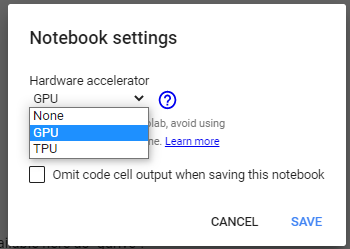

### Install Cellpose-SAM

In [1]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-9qomon8r
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-9qomon8r
  Resolved https://www.github.com/mouseland/cellpose.git to commit 70c0d07d00f7951cb7aab3c18fc306808c3c41ca
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 74.3 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.8.dev11+g70c0d07d0-py3-none-any.whl size=212476 sha256=f0bb1dbc07f1d7d6132591f260ab3f966a52b4d57ac2dec5263ad49ad0bf25f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkave56y/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


Check GPU and instantiate model - will download weights.

In [2]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-11-11 05:18:39,402 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-11-11 05:18:39,402 [INFO] 
cellpose version: 	4.0.8.dev11+g70c0d07d0 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.8.0+cu126
2025-11-11 05:18:39,599 [INFO] ** TORCH CUDA version installed and working. **
2025-11-11 05:18:39,601 [INFO] ** TORCH CUDA version installed and working. **
2025-11-11 05:18:39,601 [INFO] >>>> using GPU (CUDA)
2025-11-11 05:18:42,711 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:03<00:00, 402MB/s]


### Download example images

100%|██████████| 21.3M/21.3M [00:02<00:00, 7.63MB/s]
100%|██████████| 1.63M/1.63M [00:01<00:00, 1.29MB/s]


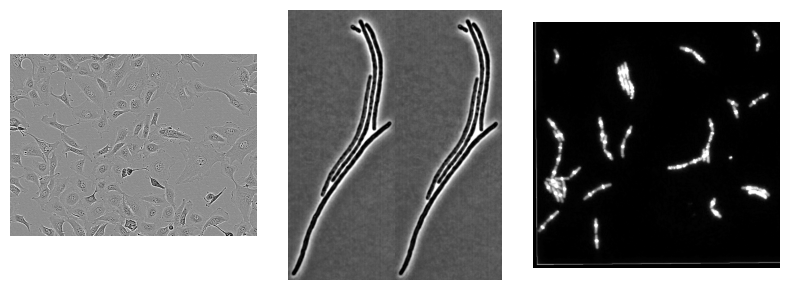

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import utils, io

# download example 2D images from website
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
utils.download_url_to_file(url, filename)

# download 3D tiff
url = "http://www.cellpose.org/static/data/rgb_3D.tif"
utils.download_url_to_file(url, "rgb_3D.tif")

dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["imgs"]
masks_true = dat["masks_true"]

plt.figure(figsize=(8,3))
for i, iex in enumerate([9, 16, 21]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Run Cellpose-SAM

In [4]:
masks_pred, flows, styles = model.eval(imgs, niter=1000) # using more iterations for bacteria


2025-11-11 05:19:23,566 [INFO] 100%|##########| 24/24 [00:30<00:00,  1.27s/it]


plot results

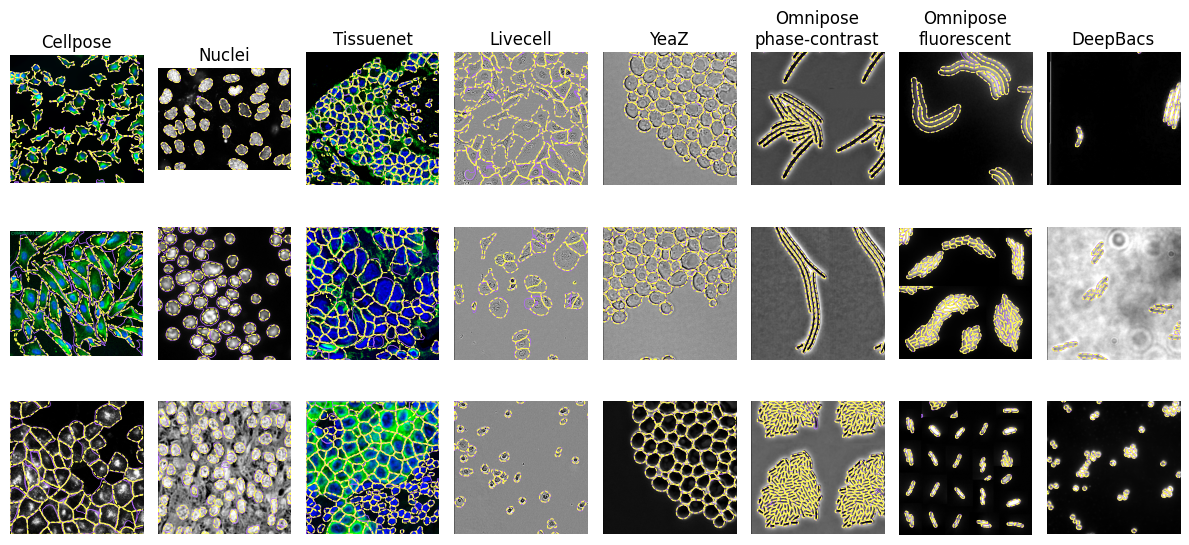

In [5]:
from cellpose import transforms, plot

titles = [
        "Cellpose", "Nuclei", "Tissuenet", "Livecell", "YeaZ",
         "Omnipose\nphase-contrast", "Omnipose\nfluorescent",
        "DeepBacs"
    ]

plt.figure(figsize=(12,6))
ly = 400
for iex in range(len(imgs)):
    img = imgs[iex].squeeze().copy()
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1) # normalize images across channel axis
    ax = plt.subplot(3, 8, (iex%3)*8 + (iex//3) +1)
    if img[1].sum()==0:
        img = img[0]
        ax.imshow(img, cmap="gray")
    else:
        # make RGB from 2 channel image
        img = np.concatenate((np.zeros_like(img)[:1], img), axis=0).transpose(1,2,0)
        ax.imshow(img)
    ax.set_ylim([0, min(400, img.shape[0])])
    ax.set_xlim([0, min(400, img.shape[1])])


    # GROUND-TRUTH = PURPLE
    # PREDICTED = YELLOW
    outlines_gt = utils.outlines_list(masks_true[iex])
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_gt:
        plt.plot(o[:,0], o[:,1], color=[0.7,0.4,1], lw=0.5)
    for o in outlines_pred:
        plt.plot(o[:,0], o[:,1], color=[1,1,0.3], lw=0.75, ls="--")
    plt.axis('off')

    if iex%3 == 0:
        ax.set_title(titles[iex//3])

plt.tight_layout()
plt.show()

# Run Cellpose-SAM in 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



In [6]:
img_3D = io.imread("rgb_3D.tif")


# 1. computes flows from 2D slices and combines into 3D flows to create masks
masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                batch_size=32,
                                do_3D=True, flow3D_smooth=1)


2025-11-11 05:19:37,626 [INFO] reading tiff with 150 planes


100%|██████████| 150/150 [00:00<00:00, 8319.94it/s]

2025-11-11 05:19:37,669 [INFO] running YX: 75 planes of size (75, 75)
2025-11-11 05:19:37,670 [INFO] 0%|          | 0/3 [00:00<?, ?it/s]


2025-11-11 05:19:41,471 [INFO] 100%|##########| 3/3 [00:03<00:00,  1.27s/it]
2025-11-11 05:19:41,478 [INFO] running ZY: 75 planes of size (75, 75)
2025-11-11 05:19:45,264 [INFO] 100%|##########| 3/3 [00:03<00:00,  1.26s/it]
2025-11-11 05:19:45,271 [INFO] running ZX: 75 planes of size (75, 75)
2025-11-11 05:19:49,080 [INFO] 100%|##########| 3/3 [00:03<00:00,  1.27s/it]
2025-11-11 05:19:49,089 [INFO] network run in 11.42s
2025-11-11 05:19:49,090 [INFO] smoothing flows with sigma=1
2025-11-11 05:19:49,640 [INFO] masks created in 0.07s


Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [7]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                                  batch_size=32,
                                                  do_3D=False, stitch_threshold=0.5)

running cellpose 2D + stitching masks
2025-11-11 05:19:53,486 [INFO] 100%|##########| 3/3 [00:03<00:00,  1.26s/it]
2025-11-11 05:19:53,487 [INFO] network run in 3.80s
2025-11-11 05:19:58,073 [INFO] 100%|##########| 75/75 [00:04<00:00, 16.40it/s]
2025-11-11 05:19:58,074 [INFO] stitching 75 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 74/74 [00:00<00:00, 1673.39it/s]

2025-11-11 05:19:58,131 [INFO] masks created in 4.63s


Results from 3D flows => masks computation

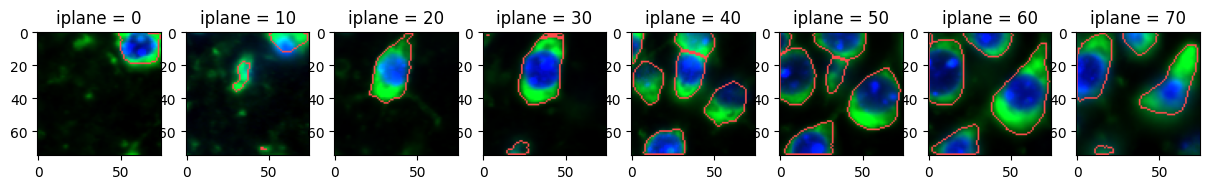

In [8]:
# DISPLAY RESULTS 3D flows => masks
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

Results from stitching

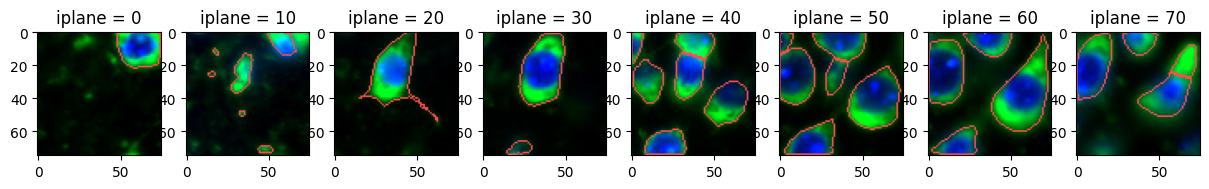

In [9]:
# DISPLAY RESULTS stitching
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks_stitched[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

data_folder_path = "/content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/images"

if os.path.exists(data_folder_path):
    files_in_folder = os.listdir(data_folder_path)
    if files_in_folder:
        print(f"Files in '{data_folder_path}':")
        for file_name in files_in_folder:
            print(file_name)
    else:
        print(f"The folder '{data_folder_path}' is empty.")
else:
    print(f"The folder '{data_folder_path}' does not exist.")

Files in '/content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/images':
01_t000.tif
01_t142.tif
01_t120.tif
01_t184.tif
01_t073.tif
01_t080.tif
01_t132.tif
01_t164.tif
01_t098.tif
01_t153.tif
01_t086.tif
01_t093.tif
01_t139.tif
01_t106.tif
01_t193.tif
01_t187.tif
01_t140.tif
01_t016.tif
01_t085.tif
01_t101.tif
02_t128.tif
02_t188.tif
02_t095.tif
02_t051.tif
02_t080.tif
02_t149.tif
02_t138.tif
02_t120.tif
02_t090.tif
02_t124.tif
02_t054.tif
02_t136.tif
02_t076.tif
02_t167.tif
02_t000.tif
02_t016.tif
02_t182.tif
02_t037.tif
02_t162.tif


In [14]:
import tifffile as tiff
from cellpose import models, io
import glob
from natsort import natsorted
import os
import numpy as np
import pandas as pd
from skimage import measure
import matplotlib.pyplot as plt

def calculate_binary_metrics(pred_mask, true_mask):
    """Calculate binary segmentation metrics (IoU, Precision, Recall, F1)"""
    # Convert to binary masks
    pred_binary = (pred_mask > 0).astype(bool)
    true_binary = (true_mask > 0).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(pred_binary, true_binary)
    union = np.logical_or(pred_binary, true_binary)

    # Avoid division by zero
    if union.sum() == 0:
        iou = 1.0 if intersection.sum() == 0 else 0.0
    else:
        iou = intersection.sum() / union.sum()

    # Calculate precision, recall, f1
    true_positive = intersection.sum()
    false_positive = np.logical_and(pred_binary, ~true_binary).sum()
    false_negative = np.logical_and(~pred_binary, true_binary).sum()

    # Precision
    if (true_positive + false_positive) == 0:
        precision = 0.0
    else:
        precision = true_positive / (true_positive + false_positive)

    # Recall
    if (true_positive + false_negative) == 0:
        recall = 0.0
    else:
        recall = true_positive / (true_positive + false_negative)

    # F1 Score
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positive': true_positive,
        'false_positive': false_positive,
        'false_negative': false_negative
    }

def calculate_instance_metrics(pred_mask, true_mask, iou_threshold=0.5):
    """Calculate instance segmentation metrics using bipartite matching"""
    from scipy.optimize import linear_sum_assignment

    # Get unique labels (exclude background 0)
    pred_labels = np.unique(pred_mask)[1:]  # Exclude background
    true_labels = np.unique(true_mask)[1:]  # Exclude background

    # If no instances in either mask
    if len(pred_labels) == 0 and len(true_labels) == 0:
        return {'ap': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'matched_pairs': 0}
    elif len(pred_labels) == 0 or len(true_labels) == 0:
        return {'ap': 0.0, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'matched_pairs': 0}

    # Create cost matrix
    cost_matrix = np.zeros((len(pred_labels), len(true_labels)))

    for i, pred_label in enumerate(pred_labels):
        pred_instance = (pred_mask == pred_label)
        pred_area = pred_instance.sum()

        for j, true_label in enumerate(true_labels):
            true_instance = (true_mask == true_label)
            true_area = true_instance.sum()

            # Calculate intersection and union
            intersection = np.logical_and(pred_instance, true_instance).sum()
            union = pred_area + true_area - intersection

            # IoU
            if union > 0:
                iou = intersection / union
            else:
                iou = 0.0

            # Use 1-IoU as cost (we want to minimize cost = maximize IoU)
            cost_matrix[i, j] = 1 - iou

    # Hungarian algorithm for optimal matching
    pred_indices, true_indices = linear_sum_assignment(cost_matrix)

    # Count matches above IoU threshold
    matched_pairs = 0
    for pred_idx, true_idx in zip(pred_indices, true_indices):
        iou = 1 - cost_matrix[pred_idx, true_idx]
        if iou >= iou_threshold:
            matched_pairs += 1

    # Calculate metrics
    precision = matched_pairs / len(pred_labels) if len(pred_labels) > 0 else 0
    recall = matched_pairs / len(true_labels) if len(true_labels) > 0 else 0

    # F1 Score
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    # Average Precision (AP) - simple version
    ap = matched_pairs / max(len(true_labels), 1)

    return {
        'ap': ap,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'matched_pairs': matched_pairs,
        'predicted_instances': len(pred_labels),
        'true_instances': len(true_labels)
    }

def validate_and_fix_mask(mask, filename):
    """Validate and fix 3D mask for ImageJ compatibility"""
    print(f"=== Validating {filename} ===")
    print(f"Original shape: {mask.shape}")
    print(f"Original dtype: {mask.dtype}")
    print(f"Original value range: {mask.min()} to {mask.max()}")

    # Fix 1: Ensure positive values only
    if np.any(mask < 0):
        print(f"❌ Fixing negative values: {np.sum(mask < 0)} pixels")
        mask = np.clip(mask, 0, None)

    # Fix 2: Remove NaN and infinite values
    if np.any(np.isnan(mask)):
        print(f"❌ Fixing NaN values: {np.sum(np.isnan(mask))} pixels")
        mask = np.nan_to_num(mask, nan=0)

    if np.any(np.isinf(mask)):
        print(f"❌ Fixing infinite values: {np.sum(np.isinf(mask))} pixels")
        mask = np.where(np.isinf(mask), 0, mask)

    # Fix 3: Convert to uint16 for ImageJ compatibility
    if mask.dtype != np.uint16:
        print(f"🔄 Converting from {mask.dtype} to uint16")
        mask = mask.astype(np.uint16)

    # Fix 4: Ensure values are within uint16 range
    if mask.max() > 65535:
        print(f"⚠️ Clipping values exceeding uint16 range")
        mask = np.clip(mask, 0, 65535)

    # Fix 5: Relabel to ensure consecutive labels (important for ImageJ)
    print("🔄 Relabeling masks for consecutive labels...")
    unique_labels = np.unique(mask)
    if len(unique_labels) > 1:  # Only relabel if we have actual objects
        mask_relabeled = np.zeros_like(mask)
        current_label = 1

        for old_label in unique_labels:
            if old_label == 0:  # Keep background as 0
                continue
            mask_relabeled[mask == old_label] = current_label
            current_label += 1
        mask = mask_relabeled
    else:
        print("⚠️ No objects found in mask")

    print(f"✅ Fixed shape: {mask.shape}")
    print(f"✅ Fixed dtype: {mask.dtype}")
    print(f"✅ Fixed value range: {mask.min()} to {mask.max()}")
    print(f"✅ Number of instances: {len(np.unique(mask)) - 1}")

    return mask

def save_mask_imagej_compatible(mask, filepath):
    """Save mask in ImageJ-compatible format"""
    # Apply all fixes
    mask_fixed = validate_and_fix_mask(mask, os.path.basename(filepath))

    # Save with ImageJ metadata
    print(f"💾 Saving to: {filepath}")
    tiff.imwrite(
        filepath,
        mask_fixed,
        imagej=True,
        metadata={
            'mode': 'grayscale',
            'unit': 'um',
            'spacing': 1.0,
            'axes': 'ZYX'
        }
    )

    # Verify the saved file
    try:
        saved_mask = tiff.imread(filepath)
        print(f"✅ Verification - Saved shape: {saved_mask.shape}, dtype: {saved_mask.dtype}")
        print(f"✅ Verification - Value range: {saved_mask.min()} to {saved_mask.max()}")
    except Exception as e:
        print(f"❌ Verification failed: {e}")

    return mask_fixed

def create_simple_visualization(mask, original_img, save_path):
    """Create a simple 2D visualization for quick checking"""
    import matplotlib.pyplot as plt

    # Take middle slice
    z_slice = mask.shape[0] // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    if original_img is not None:
        axes[0].imshow(original_img[z_slice], cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

    # Mask
    axes[1].imshow(mask[z_slice], cmap='nipy_spectral')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    # Overlay - FIXED: Use 'Reds' instead of 'red'
    if original_img is not None:
        from skimage.segmentation import find_boundaries
        boundaries = find_boundaries(mask[z_slice])
        axes[2].imshow(original_img[z_slice], cmap='gray')
        axes[2].imshow(boundaries, cmap='Reds', alpha=0.6)  # FIXED: 'Reds' not 'red'
        axes[2].set_title('Boundaries Overlay')
        axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"📊 Visualization saved to: {save_path}")

def create_metrics_visualization(metrics_df, save_path):
    """Create a visualization of the metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Binary metrics
    binary_metrics = ['iou', 'precision', 'recall', 'f1_score']
    for i, metric in enumerate(binary_metrics):
        axes[0,0].plot(metrics_df[metric], label=metric.upper())
    axes[0,0].set_title('Binary Segmentation Metrics')
    axes[0,0].set_xlabel('Image Index')
    axes[0,0].set_ylabel('Score')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Instance metrics
    instance_metrics = ['instance_precision', 'instance_recall', 'instance_f1_score']
    for metric in instance_metrics:
        axes[0,1].plot(metrics_df[metric], label=metric.replace('instance_', '').upper())
    axes[0,1].set_title('Instance Segmentation Metrics')
    axes[0,1].set_xlabel('Image Index')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Instance counts
    axes[1,0].plot(metrics_df['predicted_instances'], label='Predicted', marker='o')
    axes[1,0].plot(metrics_df['true_instances'], label='Ground Truth', marker='s')
    axes[1,0].set_title('Instance Counts')
    axes[1,0].set_xlabel('Image Index')
    axes[1,0].set_ylabel('Number of Instances')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Matched pairs
    axes[1,1].bar(range(len(metrics_df)), metrics_df['matched_pairs'])
    axes[1,1].set_title('Matched Instance Pairs')
    axes[1,1].set_xlabel('Image Index')
    axes[1,1].set_ylabel('Number of Matches')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"📈 Metrics visualization saved to: {save_path}")

# Main execution
data_folder = "/content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/"

# Get test image files and corresponding ground truth files
test_img_files = natsorted(glob.glob(data_folder + 'test/images/*.tif*'))
ground_truth_files = natsorted(glob.glob(data_folder + 'test/masks/*.tif*'))

print(f"Found {len(test_img_files)} test images")
print(f"Found {len(ground_truth_files)} ground truth masks")

# Initialize results storage
all_metrics = []

# Initialize Cellpose model
print("Initializing Cellpose model...")
model = models.CellposeModel(gpu=True, model_type='nuclei')
print("Model loaded successfully!")

# Process each test image
for i, (img_path, gt_path) in enumerate(zip(test_img_files, ground_truth_files)):
    print(f"\n{'='*60}")
    print(f"Processing image {i+1}/{len(test_img_files)}: {os.path.basename(img_path)}")
    print(f"Ground truth: {os.path.basename(gt_path)}")

    # Read the 3D image and ground truth
    print("📥 Reading image and ground truth...")
    img_3D = io.imread(img_path)
    gt_mask = io.imread(gt_path)

    print(f"Input image shape: {img_3D.shape}")
    print(f"Ground truth shape: {gt_mask.shape}")
    print(f"Input image range: {img_3D.min()} to {img_3D.max()}")
    print(f"Ground truth instances: {len(np.unique(gt_mask)) - 1}")

    # Check if image needs normalization
    if img_3D.dtype == np.uint16:
        print("🔄 Converting uint16 to float32 for processing...")
        img_3D = img_3D.astype(np.float32)

    try:
        print("🎯 Starting segmentation...")
        # Compute masks - simplified parameters
        masks, flows, styles = model.eval(
            img_3D,
            channels=[0, 0],  # grayscale image
            z_axis=0,
            channel_axis=None,  # Changed from 1 to None for 3D
            do_3D=True,
            batch_size=4,  # reduced for stability
            progress=True   # show progress bar
        )

        print(f"✅ Segmentation completed!")
        print(f"Output masks shape: {masks.shape}")
        print(f"Number of cells detected: {len(np.unique(masks)) - 1}")

        # Save the 3D masks with fixes
        base_name = os.path.basename(img_path).replace('.tif', '')
        mask_save_dir = os.path.join(data_folder, 'test/cellpose_masks_fixed/')
        os.makedirs(mask_save_dir, exist_ok=True)
        mask_save_path = os.path.join(mask_save_dir, f'{base_name}_masks.tif')

        # Apply fixes and save
        masks_fixed = save_mask_imagej_compatible(masks, mask_save_path)

        # Calculate performance metrics
        print("📊 Calculating performance metrics...")

        # Binary segmentation metrics
        binary_metrics = calculate_binary_metrics(masks_fixed, gt_mask)

        # Instance segmentation metrics
        instance_metrics = calculate_instance_metrics(masks_fixed, gt_mask, iou_threshold=0.5)

        # Combine all metrics
        image_metrics = {
            'image_name': os.path.basename(img_path),
            **binary_metrics,
            'instance_ap': instance_metrics['ap'],
            'instance_precision': instance_metrics['precision'],
            'instance_recall': instance_metrics['recall'],
            'instance_f1_score': instance_metrics['f1_score'],
            'matched_pairs': instance_metrics['matched_pairs'],
            'predicted_instances': instance_metrics['predicted_instances'],
            'true_instances': instance_metrics['true_instances']
        }

        all_metrics.append(image_metrics)

        # Print metrics for this image
        print(f"📈 Binary Metrics - IoU: {binary_metrics['iou']:.3f}, "
              f"Precision: {binary_metrics['precision']:.3f}, "
              f"Recall: {binary_metrics['recall']:.3f}, "
              f"F1: {binary_metrics['f1_score']:.3f}")

        print(f"📈 Instance Metrics - AP: {instance_metrics['ap']:.3f}, "
              f"Precision: {instance_metrics['precision']:.3f}, "
              f"Recall: {instance_metrics['recall']:.3f}, "
              f"F1: {instance_metrics['f1_score']:.3f}")

        print(f"📈 Instance Counts - Predicted: {instance_metrics['predicted_instances']}, "
              f"Ground Truth: {instance_metrics['true_instances']}, "
              f"Matched: {instance_metrics['matched_pairs']}")

        # Create visualization - with error handling
        try:
            viz_save_path = os.path.join(mask_save_dir, f'{base_name}_preview.png')
            create_simple_visualization(masks_fixed, img_3D, viz_save_path)
        except Exception as viz_error:
            print(f"⚠️ Visualization failed (but masks saved): {viz_error}")

        print(f"🎉 Processing completed for {os.path.basename(img_path)}")

    except Exception as e:
        print(f"❌ Error during processing: {e}")
        import traceback
        traceback.print_exc()

# Calculate and display overall statistics
if all_metrics:
    print(f"\n{'='*80}")
    print("📊 OVERALL PERFORMANCE SUMMARY")
    print('='*80)

    metrics_df = pd.DataFrame(all_metrics)

    # Calculate mean values
    overall_metrics = {
        'Mean IoU': metrics_df['iou'].mean(),
        'Mean Precision': metrics_df['precision'].mean(),
        'Mean Recall': metrics_df['recall'].mean(),
        'Mean F1 Score': metrics_df['f1_score'].mean(),
        'Mean Instance AP': metrics_df['instance_ap'].mean(),
        'Mean Instance Precision': metrics_df['instance_precision'].mean(),
        'Mean Instance Recall': metrics_df['instance_recall'].mean(),
        'Mean Instance F1': metrics_df['instance_f1_score'].mean(),
        'Total Predicted Instances': metrics_df['predicted_instances'].sum(),
        'Total True Instances': metrics_df['true_instances'].sum(),
        'Total Matched Pairs': metrics_df['matched_pairs'].sum()
    }

    # Print overall metrics
    for metric, value in overall_metrics.items():
        if 'Instances' in metric or 'Pairs' in metric:
            print(f"{metric}: {value:.0f}")
        else:
            print(f"{metric}: {value:.4f}")

    # Save detailed metrics to CSV
    metrics_csv_path = os.path.join(data_folder, 'test/performance_metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)
    print(f"\n💾 Detailed metrics saved to: {metrics_csv_path}")

    # Create metrics visualization
    try:
        metrics_viz_path = os.path.join(data_folder, 'test/metrics_visualization.png')
        create_metrics_visualization(metrics_df, metrics_viz_path)
    except Exception as e:
        print(f"⚠️ Metrics visualization failed: {e}")

    # Print per-image summary
    print(f"\n📋 PER-IMAGE METRICS SUMMARY:")
    print(metrics_df[['image_name', 'iou', 'f1_score', 'instance_f1_score', 'predicted_instances', 'true_instances']].to_string(index=False))

print("\n" + "="*60)
print("🎊 All processing completed successfully!")
print(f"📁 Masks saved to: {data_folder}test/cellpose_masks_fixed/")
print(f"📊 Performance metrics calculated for {len(all_metrics)} images")

2025-11-09 22:49:25,991 [INFO] NumExpr defaulting to 2 threads.
Found 39 test images
Found 39 ground truth masks
Initializing Cellpose model...
2025-11-09 22:49:26,137 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-11-09 22:49:26,138 [INFO] ** TORCH CUDA version installed and working. **
2025-11-09 22:49:26,139 [INFO] >>>> using GPU (CUDA)
2025-11-09 22:49:28,536 [INFO] >>>> loading model /root/.cellpose/models/cpsam
Model loaded successfully!

Processing image 1/39: 01_t000.tif
Ground truth: 01_mask000.tif
📥 Reading image and ground truth...
2025-11-09 22:49:29,690 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 124.37it/s]


2025-11-09 22:49:30,232 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 276.01it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 4
🎯 Starting segmentation...
2025-11-09 22:49:30,900 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-09 22:49:31,471 [INFO] running YX: 35 planes of size (512, 708)
2025-11-09 22:51:48,815 [INFO] 100%|##########| 35/35 [02:17<00:00,  3.92s/it]
2025-11-09 22:51:49,072 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-09 23:02:59,589 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-09 23:02:59,741 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-09 23:14:36,203 [INFO] 100%|##########| 708/708 [11:36<00:00,  1.02it/s]
2025-11-09 23:14:36,548 [INFO] network run in 1505.08s
2025-11-09 23:14:38,206 [INFO] masks created in 0.73s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 6
=== Validating 01_t000_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 6
🔄 Relabeling masks for consec

100%|██████████| 35/35 [00:00<00:00, 261.95it/s]


2025-11-09 23:14:44,446 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 628.19it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 246


Ground truth instances: 8
🎯 Starting segmentation...
2025-11-09 23:14:44,716 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-09 23:14:45,070 [INFO] running YX: 35 planes of size (512, 708)
2025-11-09 23:17:03,540 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-09 23:17:03,862 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-09 23:28:13,328 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-09 23:28:13,486 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-09 23:39:49,613 [INFO] 100%|##########| 708/708 [11:36<00:00,  1.02it/s]
2025-11-09 23:39:50,081 [INFO] network run in 1505.01s
2025-11-09 23:39:52,252 [INFO] masks created in 1.03s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 32
=== Validating 01_t016_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 32
🔄 Relabeling masks for cons

100%|██████████| 35/35 [00:00<00:00, 252.76it/s]


2025-11-09 23:40:02,098 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 579.08it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 51
🎯 Starting segmentation...
2025-11-09 23:40:02,436 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-09 23:40:02,965 [INFO] running YX: 35 planes of size (512, 708)
2025-11-09 23:42:21,647 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-09 23:42:21,911 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-09 23:53:31,943 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-09 23:53:32,097 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 00:05:07,712 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 00:05:08,074 [INFO] network run in 1505.11s
2025-11-10 00:05:09,762 [INFO] masks created in 0.81s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 53
=== Validating 01_t073_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 53
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 251.68it/s]


2025-11-10 00:06:11,976 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 574.14it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 53
🎯 Starting segmentation...
2025-11-10 00:06:12,257 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 00:06:12,622 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 00:08:31,446 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.97s/it]
2025-11-10 00:08:31,727 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 00:19:41,094 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 00:19:41,317 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 00:31:17,500 [INFO] 100%|##########| 708/708 [11:36<00:00,  1.02it/s]
2025-11-10 00:31:17,852 [INFO] network run in 1505.23s
2025-11-10 00:31:19,528 [INFO] masks created in 0.80s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 54
=== Validating 01_t080_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 54
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 245.05it/s]


2025-11-10 00:32:25,907 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 584.21it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 15 to 255


Ground truth instances: 59
🎯 Starting segmentation...
2025-11-10 00:32:26,194 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 00:32:26,550 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 00:34:45,217 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-10 00:34:45,485 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 00:45:54,822 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 00:45:54,986 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 00:57:30,689 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 00:57:31,056 [INFO] network run in 1504.51s
2025-11-10 00:57:32,720 [INFO] masks created in 0.78s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 61
=== Validating 01_t085_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 61
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 246.54it/s]


2025-11-10 00:58:53,858 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 553.93it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 67
🎯 Starting segmentation...
2025-11-10 00:58:54,169 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 00:58:54,683 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 01:01:13,389 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-10 01:01:13,663 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 01:12:23,746 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-10 01:12:23,898 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 01:23:59,576 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 01:23:59,938 [INFO] network run in 1505.25s
2025-11-10 01:24:02,131 [INFO] masks created in 1.06s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 77
=== Validating 01_t086_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 77
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 238.93it/s]


2025-11-10 01:25:53,354 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 551.84it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 88
🎯 Starting segmentation...
2025-11-10 01:25:53,630 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 01:25:53,976 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 01:28:12,653 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-10 01:28:12,916 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 01:39:23,196 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-10 01:39:23,427 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 01:50:59,990 [INFO] 100%|##########| 708/708 [11:36<00:00,  1.02it/s]
2025-11-10 01:51:00,346 [INFO] network run in 1506.37s
2025-11-10 01:51:02,025 [INFO] masks created in 0.81s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 92
=== Validating 01_t093_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 92
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 243.88it/s]


2025-11-10 01:54:00,930 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 562.72it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 92
🎯 Starting segmentation...
2025-11-10 01:54:01,205 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 01:54:01,568 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 01:56:20,399 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.97s/it]
2025-11-10 01:56:20,658 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 02:07:30,787 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-10 02:07:31,010 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 02:19:07,074 [INFO] 100%|##########| 708/708 [11:36<00:00,  1.02it/s]
2025-11-10 02:19:07,432 [INFO] network run in 1505.86s
2025-11-10 02:19:09,103 [INFO] masks created in 0.86s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 95
=== Validating 01_t098_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 95
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 238.87it/s]


2025-11-10 02:22:19,477 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 559.48it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 95
🎯 Starting segmentation...
2025-11-10 02:22:19,758 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 02:22:20,116 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 02:24:36,056 [INFO] 100%|##########| 35/35 [02:15<00:00,  3.88s/it]
2025-11-10 02:24:36,316 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 02:35:45,799 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 02:35:45,967 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 02:47:21,215 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 02:47:21,583 [INFO] network run in 1501.47s
2025-11-10 02:47:23,327 [INFO] masks created in 0.84s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 97
=== Validating 01_t101_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 97
🔄 Relabeling masks for con

100%|██████████| 35/35 [00:00<00:00, 237.02it/s]


2025-11-10 02:50:42,209 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 555.31it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 100
🎯 Starting segmentation...
2025-11-10 02:50:42,492 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 02:50:42,854 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 02:53:01,318 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-10 02:53:01,581 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 03:04:11,539 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 03:04:11,756 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 03:15:47,636 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 03:15:48,006 [INFO] network run in 1505.15s
2025-11-10 03:15:49,648 [INFO] masks created in 0.81s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 104
=== Validating 01_t106_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 104
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 233.60it/s]


2025-11-10 03:19:26,876 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 551.90it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 127
🎯 Starting segmentation...
2025-11-10 03:19:27,156 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 03:19:27,526 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 03:21:46,111 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.96s/it]
2025-11-10 03:21:46,422 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 03:32:56,155 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 03:32:56,316 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 03:44:31,387 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 03:44:31,761 [INFO] network run in 1504.23s
2025-11-10 03:44:33,557 [INFO] masks created in 0.90s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 128
=== Validating 01_t120_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 128
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 237.56it/s]


2025-11-10 03:50:19,247 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 332.52it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 179
🎯 Starting segmentation...
2025-11-10 03:50:19,748 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 03:50:20,254 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 03:52:38,152 [INFO] 100%|##########| 35/35 [02:17<00:00,  3.94s/it]
2025-11-10 03:52:38,421 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 04:03:49,259 [INFO] 100%|##########| 512/512 [11:10<00:00,  1.31s/it]
2025-11-10 04:03:49,416 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 04:15:25,171 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 04:15:25,576 [INFO] network run in 1505.32s
2025-11-10 04:15:27,332 [INFO] masks created in 0.87s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 181
=== Validating 01_t132_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 181
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 216.74it/s]


2025-11-10 04:26:44,307 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 520.77it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 186
🎯 Starting segmentation...
2025-11-10 04:26:44,600 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 04:26:44,954 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 04:29:00,336 [INFO] 100%|##########| 35/35 [02:15<00:00,  3.87s/it]
2025-11-10 04:29:00,613 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 04:40:09,515 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 04:40:09,738 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 04:51:45,603 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 04:51:45,971 [INFO] network run in 1501.02s
2025-11-10 04:51:47,767 [INFO] masks created in 0.92s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 185
=== Validating 01_t139_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 185
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 235.93it/s]


2025-11-10 05:03:52,927 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 524.44it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 186
🎯 Starting segmentation...
2025-11-10 05:03:53,213 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 05:03:53,592 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 05:06:07,773 [INFO] 100%|##########| 35/35 [02:14<00:00,  3.83s/it]
2025-11-10 05:06:08,043 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 05:17:16,884 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 05:17:17,100 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 05:28:52,567 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 05:28:52,937 [INFO] network run in 1499.35s
2025-11-10 05:28:54,680 [INFO] masks created in 0.90s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 184
=== Validating 01_t140_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 184
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 233.32it/s]


2025-11-10 05:40:38,661 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 429.80it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 12 to 255


Ground truth instances: 186
🎯 Starting segmentation...
2025-11-10 05:40:38,967 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 05:40:39,318 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 05:42:51,959 [INFO] 100%|##########| 35/35 [02:12<00:00,  3.79s/it]
2025-11-10 05:42:52,227 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 05:54:00,955 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 05:54:01,109 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 06:05:36,868 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 06:05:37,324 [INFO] network run in 1498.01s
2025-11-10 06:05:39,478 [INFO] masks created in 1.05s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 192
=== Validating 01_t142_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 192
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 151.38it/s]


2025-11-10 06:17:53,252 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 347.27it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 193
🎯 Starting segmentation...
2025-11-10 06:17:53,581 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 06:17:53,951 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 06:20:12,363 [INFO] 100%|##########| 35/35 [02:18<00:00,  3.95s/it]
2025-11-10 06:20:12,688 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 06:31:21,836 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 06:31:21,996 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 06:42:56,646 [INFO] 100%|##########| 708/708 [11:34<00:00,  1.02it/s]
2025-11-10 06:42:57,016 [INFO] network run in 1503.07s
2025-11-10 06:42:58,784 [INFO] masks created in 0.92s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 197
=== Validating 01_t153_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 197
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 231.18it/s]


2025-11-10 06:56:01,017 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 480.09it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 232
🎯 Starting segmentation...
2025-11-10 06:56:01,316 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 06:56:01,684 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 06:58:18,487 [INFO] 100%|##########| 35/35 [02:16<00:00,  3.91s/it]
2025-11-10 06:58:18,756 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 07:09:28,214 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 07:09:28,377 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 07:21:03,887 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 07:21:04,282 [INFO] network run in 1502.60s
2025-11-10 07:21:06,122 [INFO] masks created in 0.97s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 226
=== Validating 01_t164_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 226
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 212.54it/s]


2025-11-10 07:38:53,451 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 502.03it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 353
🎯 Starting segmentation...
2025-11-10 07:38:53,748 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 07:38:54,098 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 07:41:11,019 [INFO] 100%|##########| 35/35 [02:16<00:00,  3.91s/it]
2025-11-10 07:41:11,295 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 07:52:20,315 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 07:52:20,494 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 08:03:55,766 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 08:03:56,212 [INFO] network run in 1502.11s
2025-11-10 08:03:58,600 [INFO] masks created in 1.31s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 333
=== Validating 01_t184_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 333
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 202.81it/s]


2025-11-10 08:44:53,584 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 485.96it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 12 to 255


Ground truth instances: 359
🎯 Starting segmentation...
2025-11-10 08:44:53,907 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 08:44:54,266 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 08:47:11,648 [INFO] 100%|##########| 35/35 [02:17<00:00,  3.93s/it]
2025-11-10 08:47:11,933 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 08:58:21,683 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 08:58:21,926 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 09:09:57,362 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 09:09:57,837 [INFO] network run in 1503.57s
2025-11-10 09:10:00,146 [INFO] masks created in 1.17s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 342
=== Validating 01_t187_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 342
🔄 Relabeling masks for 

100%|██████████| 35/35 [00:00<00:00, 228.05it/s]


2025-11-10 09:52:50,244 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 469.21it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 362
🎯 Starting segmentation...
2025-11-10 09:52:50,551 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 09:52:50,909 [INFO] running YX: 35 planes of size (512, 708)
2025-11-10 09:55:08,187 [INFO] 100%|##########| 35/35 [02:17<00:00,  3.92s/it]
2025-11-10 09:55:08,467 [INFO] running ZY: 512 planes of size (35, 708)
2025-11-10 10:06:17,750 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 10:06:17,912 [INFO] running ZX: 708 planes of size (35, 512)
2025-11-10 10:17:53,586 [INFO] 100%|##########| 708/708 [11:35<00:00,  1.02it/s]
2025-11-10 10:17:54,071 [INFO] network run in 1503.16s
2025-11-10 10:17:56,680 [INFO] masks created in 1.47s
✅ Segmentation completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 331
=== Validating 01_t193_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 331
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 131.85it/s]


2025-11-10 10:59:42,937 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 394.03it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 2
🎯 Starting segmentation...
2025-11-10 10:59:43,225 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 10:59:43,555 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 11:01:45,060 [INFO] 100%|##########| 31/31 [02:01<00:00,  3.92s/it]
2025-11-10 11:01:45,299 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 11:12:54,428 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 11:12:54,639 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 11:24:32,714 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 11:24:33,050 [INFO] network run in 1489.49s
2025-11-10 11:24:34,585 [INFO] masks created in 0.67s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 68
=== Validating 02_t000_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 68
🔄 Relabeling masks for cons

100%|██████████| 31/31 [00:00<00:00, 202.61it/s]


2025-11-10 11:24:43,119 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 622.86it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 7
🎯 Starting segmentation...
2025-11-10 11:24:43,364 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 11:24:43,696 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 11:26:46,388 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 11:26:46,704 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 11:37:55,239 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 11:37:55,381 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 11:49:33,237 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 11:49:33,567 [INFO] network run in 1489.87s
2025-11-10 11:49:35,064 [INFO] masks created in 0.67s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 14
=== Validating 02_t016_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 14
🔄 Relabeling masks for cons

100%|██████████| 31/31 [00:00<00:00, 205.04it/s]


2025-11-10 11:49:42,064 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 570.70it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 15
🎯 Starting segmentation...
2025-11-10 11:49:42,327 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 11:49:42,643 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 11:51:45,089 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 11:51:45,323 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 12:02:54,317 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 12:02:54,459 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 12:14:32,862 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 12:14:33,302 [INFO] network run in 1490.66s
2025-11-10 12:14:34,914 [INFO] masks created in 0.67s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 17
=== Validating 02_t037_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 17
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 181.53it/s]


2025-11-10 12:14:43,610 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 420.14it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 28
🎯 Starting segmentation...
2025-11-10 12:14:44,009 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 12:14:44,469 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 12:16:47,059 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 12:16:47,296 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 12:27:56,396 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 12:27:56,588 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 12:39:35,152 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 12:39:35,595 [INFO] network run in 1491.13s
2025-11-10 12:39:37,597 [INFO] masks created in 0.91s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 30
=== Validating 02_t051_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 30
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 196.26it/s]


2025-11-10 12:39:57,840 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 557.89it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 28
🎯 Starting segmentation...
2025-11-10 12:39:58,090 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 12:39:58,412 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 12:42:01,101 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 12:42:01,402 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 12:53:10,514 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 12:53:10,723 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 13:04:49,101 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 13:04:49,441 [INFO] network run in 1491.03s
2025-11-10 13:04:51,006 [INFO] masks created in 0.72s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 29
=== Validating 02_t054_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 29
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 195.93it/s]


2025-11-10 13:05:11,190 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 519.72it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 52
🎯 Starting segmentation...
2025-11-10 13:05:11,451 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 13:05:11,770 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 13:07:14,469 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 13:07:14,761 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 13:18:23,197 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 13:18:23,345 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 13:30:01,486 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 13:30:01,834 [INFO] network run in 1490.06s
2025-11-10 13:30:03,880 [INFO] masks created in 0.99s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 52
=== Validating 02_t076_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 52
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 200.47it/s]


2025-11-10 13:30:59,031 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 496.40it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 54
🎯 Starting segmentation...
2025-11-10 13:30:59,297 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 13:30:59,613 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 13:33:02,268 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 13:33:02,561 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 13:44:11,511 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 13:44:11,656 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 13:55:49,838 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 13:55:50,258 [INFO] network run in 1490.64s
2025-11-10 13:55:52,312 [INFO] masks created in 0.95s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 55
=== Validating 02_t080_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 55
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 194.41it/s]


2025-11-10 13:56:49,785 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 495.92it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 15 to 255


Ground truth instances: 74
🎯 Starting segmentation...
2025-11-10 13:56:50,047 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 13:56:50,361 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 13:58:53,074 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 13:58:53,310 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 14:10:01,949 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 14:10:02,095 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 14:21:40,478 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 14:21:40,814 [INFO] network run in 1490.45s
2025-11-10 14:21:42,407 [INFO] masks created in 0.72s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 77
=== Validating 02_t090_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 77
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 194.12it/s]


2025-11-10 14:23:30,777 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 490.06it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 15 to 255


Ground truth instances: 91
🎯 Starting segmentation...
2025-11-10 14:23:31,057 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 14:23:31,401 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 14:25:33,936 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 14:25:34,181 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 14:36:42,982 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 14:36:43,126 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 14:48:21,604 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 14:48:21,931 [INFO] network run in 1490.53s
2025-11-10 14:48:23,582 [INFO] masks created in 0.78s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 94
=== Validating 02_t095_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 94
🔄 Relabeling masks for con

100%|██████████| 31/31 [00:00<00:00, 126.64it/s]


2025-11-10 14:51:04,305 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 321.30it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 125
🎯 Starting segmentation...
2025-11-10 14:51:04,632 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 14:51:04,945 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 14:53:07,826 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 14:53:08,066 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 15:04:16,590 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 15:04:16,793 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 15:15:56,186 [INFO] 100%|##########| 712/712 [11:39<00:00,  1.02it/s]
2025-11-10 15:15:56,515 [INFO] network run in 1491.57s
2025-11-10 15:15:58,178 [INFO] masks created in 0.82s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 123
=== Validating 02_t120_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 123
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 198.98it/s]


2025-11-10 15:20:43,064 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 488.60it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 150
🎯 Starting segmentation...
2025-11-10 15:20:43,329 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 15:20:43,662 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 15:22:46,480 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 15:22:46,714 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 15:33:55,130 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 15:33:55,272 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 15:45:33,260 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 15:45:33,609 [INFO] network run in 1489.95s
2025-11-10 15:45:35,258 [INFO] masks created in 0.81s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 147
=== Validating 02_t124_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 147
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 199.83it/s]


2025-11-10 15:52:08,553 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 385.19it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 172
🎯 Starting segmentation...
2025-11-10 15:52:08,838 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 15:52:09,151 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 15:54:11,766 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 15:54:12,084 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 16:05:19,620 [INFO] 100%|##########| 512/512 [11:07<00:00,  1.30s/it]
2025-11-10 16:05:19,764 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 16:16:57,244 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 16:16:57,587 [INFO] network run in 1488.44s
2025-11-10 16:16:59,274 [INFO] masks created in 0.82s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 168
=== Validating 02_t128_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 168
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 208.03it/s]


2025-11-10 16:25:18,688 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 455.35it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 182
🎯 Starting segmentation...
2025-11-10 16:25:18,956 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 16:25:19,265 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 16:27:22,366 [INFO] 100%|##########| 31/31 [02:03<00:00,  3.97s/it]
2025-11-10 16:27:22,675 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 16:38:30,614 [INFO] 100%|##########| 512/512 [11:07<00:00,  1.30s/it]
2025-11-10 16:38:30,759 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 16:50:08,151 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 16:50:08,489 [INFO] network run in 1489.22s
2025-11-10 16:50:10,161 [INFO] masks created in 0.81s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 177
=== Validating 02_t136_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 177
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 129.81it/s]


2025-11-10 16:59:32,935 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 319.92it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 185
🎯 Starting segmentation...
2025-11-10 16:59:33,390 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 16:59:33,808 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 17:01:36,576 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 17:01:36,818 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 17:12:44,619 [INFO] 100%|##########| 512/512 [11:07<00:00,  1.30s/it]
2025-11-10 17:12:44,778 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 17:24:22,712 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 17:24:23,137 [INFO] network run in 1489.33s
2025-11-10 17:24:25,319 [INFO] masks created in 1.10s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 181
=== Validating 02_t138_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 181
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 201.73it/s]


2025-11-10 17:34:09,256 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 429.49it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 188
🎯 Starting segmentation...
2025-11-10 17:34:09,533 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 17:34:09,840 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 17:36:12,647 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.96s/it]
2025-11-10 17:36:12,966 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 17:47:21,490 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 17:47:21,633 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 17:58:59,278 [INFO] 100%|##########| 712/712 [11:37<00:00,  1.02it/s]
2025-11-10 17:58:59,700 [INFO] network run in 1489.86s
2025-11-10 17:59:01,545 [INFO] masks created in 0.83s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 183
=== Validating 02_t149_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 183
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 196.51it/s]


2025-11-10 18:09:54,856 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 429.40it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 267
🎯 Starting segmentation...
2025-11-10 18:09:55,157 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 18:09:55,475 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 18:11:57,946 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 18:11:58,272 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 18:23:08,151 [INFO] 100%|##########| 512/512 [11:09<00:00,  1.31s/it]
2025-11-10 18:23:08,314 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 18:34:47,189 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 18:34:47,620 [INFO] network run in 1492.15s
2025-11-10 18:34:49,615 [INFO] masks created in 0.89s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 268
=== Validating 02_t162_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 268
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 195.44it/s]


2025-11-10 18:56:35,490 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 429.72it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 308
🎯 Starting segmentation...
2025-11-10 18:56:35,769 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 18:56:36,084 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 18:58:38,553 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 18:58:38,798 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 19:09:46,572 [INFO] 100%|##########| 512/512 [11:07<00:00,  1.30s/it]
2025-11-10 19:09:46,737 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 19:21:24,980 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 19:21:25,352 [INFO] network run in 1489.27s
2025-11-10 19:21:27,179 [INFO] masks created in 0.93s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 300
=== Validating 02_t167_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 300
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 179.17it/s]


2025-11-10 19:49:20,876 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 399.50it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 353
🎯 Starting segmentation...
2025-11-10 19:49:21,181 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 19:49:21,497 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 19:51:24,042 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 19:51:24,343 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 20:02:32,563 [INFO] 100%|##########| 512/512 [11:08<00:00,  1.31s/it]
2025-11-10 20:02:32,716 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 20:14:11,306 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 20:14:11,653 [INFO] network run in 1490.16s
2025-11-10 20:14:13,593 [INFO] masks created in 1.03s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 346
=== Validating 02_t182_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 346
🔄 Relabeling masks for 

100%|██████████| 31/31 [00:00<00:00, 191.10it/s]


2025-11-10 20:52:10,865 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 430.44it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 359
🎯 Starting segmentation...
2025-11-10 20:52:11,153 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-10 20:52:11,500 [INFO] running YX: 31 planes of size (512, 712)
2025-11-10 20:54:13,821 [INFO] 100%|##########| 31/31 [02:02<00:00,  3.95s/it]
2025-11-10 20:54:14,069 [INFO] running ZY: 512 planes of size (31, 712)
2025-11-10 21:05:22,043 [INFO] 100%|##########| 512/512 [11:07<00:00,  1.30s/it]
2025-11-10 21:05:22,192 [INFO] running ZX: 712 planes of size (31, 512)
2025-11-10 21:17:00,902 [INFO] 100%|##########| 712/712 [11:38<00:00,  1.02it/s]
2025-11-10 21:17:01,310 [INFO] network run in 1489.81s
2025-11-10 21:17:03,760 [INFO] masks created in 1.34s
✅ Segmentation completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 344
=== Validating 02_t188_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 344
🔄 Relabeling masks for 

In [12]:
import tifffile as tiff
from cellpose import models, io
import glob
from natsort import natsorted
import os
import numpy as np
import pandas as pd
from skimage import measure
import matplotlib.pyplot as plt

def calculate_binary_metrics(pred_mask, true_mask):
    """Calculate binary segmentation metrics (IoU, Precision, Recall, F1)"""
    # Convert to binary masks
    pred_binary = (pred_mask > 0).astype(bool)
    true_binary = (true_mask > 0).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(pred_binary, true_binary)
    union = np.logical_or(pred_binary, true_binary)

    # Avoid division by zero
    if union.sum() == 0:
        iou = 1.0 if intersection.sum() == 0 else 0.0
    else:
        iou = intersection.sum() / union.sum()

    # Calculate precision, recall, f1
    true_positive = intersection.sum()
    false_positive = np.logical_and(pred_binary, ~true_binary).sum()
    false_negative = np.logical_and(~pred_binary, true_binary).sum()

    # Precision
    if (true_positive + false_positive) == 0:
        precision = 0.0
    else:
        precision = true_positive / (true_positive + false_positive)

    # Recall
    if (true_positive + false_negative) == 0:
        recall = 0.0
    else:
        recall = true_positive / (true_positive + false_negative)

    # F1 Score
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positive': true_positive,
        'false_positive': false_positive,
        'false_negative': false_negative
    }

def calculate_instance_metrics(pred_mask, true_mask, iou_threshold=0.5):
    """Calculate instance segmentation metrics using bipartite matching"""
    from scipy.optimize import linear_sum_assignment

    # Get unique labels (exclude background 0)
    pred_labels = np.unique(pred_mask)[1:]  # Exclude background
    true_labels = np.unique(true_mask)[1:]  # Exclude background

    # If no instances in either mask
    if len(pred_labels) == 0 and len(true_labels) == 0:
        return {'ap': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'matched_pairs': 0}
    elif len(pred_labels) == 0 or len(true_labels) == 0:
        return {'ap': 0.0, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'matched_pairs': 0}

    # Create cost matrix
    cost_matrix = np.zeros((len(pred_labels), len(true_labels)))

    for i, pred_label in enumerate(pred_labels):
        pred_instance = (pred_mask == pred_label)
        pred_area = pred_instance.sum()

        for j, true_label in enumerate(true_labels):
            true_instance = (true_mask == true_label)
            true_area = true_instance.sum()

            # Calculate intersection and union
            intersection = np.logical_and(pred_instance, true_instance).sum()
            union = pred_area + true_area - intersection

            # IoU
            if union > 0:
                iou = intersection / union
            else:
                iou = 0.0

            # Use 1-IoU as cost (we want to minimize cost = maximize IoU)
            cost_matrix[i, j] = 1 - iou

    # Hungarian algorithm for optimal matching
    pred_indices, true_indices = linear_sum_assignment(cost_matrix)

    # Count matches above IoU threshold
    matched_pairs = 0
    for pred_idx, true_idx in zip(pred_indices, true_indices):
        iou = 1 - cost_matrix[pred_idx, true_idx]
        if iou >= iou_threshold:
            matched_pairs += 1

    # Calculate metrics
    precision = matched_pairs / len(pred_labels) if len(pred_labels) > 0 else 0
    recall = matched_pairs / len(true_labels) if len(true_labels) > 0 else 0

    # F1 Score
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    # Average Precision (AP) - simple version
    ap = matched_pairs / max(len(true_labels), 1)

    return {
        'ap': ap,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'matched_pairs': matched_pairs,
        'predicted_instances': len(pred_labels),
        'true_instances': len(true_labels)
    }

def validate_and_fix_mask(mask, filename):
    """Validate and fix 3D mask for ImageJ compatibility"""
    print(f"=== Validating {filename} ===")
    print(f"Original shape: {mask.shape}")
    print(f"Original dtype: {mask.dtype}")
    print(f"Original value range: {mask.min()} to {mask.max()}")

    # Fix 1: Ensure positive values only
    if np.any(mask < 0):
        print(f"❌ Fixing negative values: {np.sum(mask < 0)} pixels")
        mask = np.clip(mask, 0, None)

    # Fix 2: Remove NaN and infinite values
    if np.any(np.isnan(mask)):
        print(f"❌ Fixing NaN values: {np.sum(np.isnan(mask))} pixels")
        mask = np.nan_to_num(mask, nan=0)

    if np.any(np.isinf(mask)):
        print(f"❌ Fixing infinite values: {np.sum(np.isinf(mask))} pixels")
        mask = np.where(np.isinf(mask), 0, mask)

    # Fix 3: Convert to uint16 for ImageJ compatibility
    if mask.dtype != np.uint16:
        print(f"🔄 Converting from {mask.dtype} to uint16")
        mask = mask.astype(np.uint16)

    # Fix 4: Ensure values are within uint16 range
    if mask.max() > 65535:
        print(f"⚠️ Clipping values exceeding uint16 range")
        mask = np.clip(mask, 0, 65535)

    # Fix 5: Relabel to ensure consecutive labels (important for ImageJ)
    print("🔄 Relabeling masks for consecutive labels...")
    unique_labels = np.unique(mask)
    if len(unique_labels) > 1:  # Only relabel if we have actual objects
        mask_relabeled = np.zeros_like(mask)
        current_label = 1

        for old_label in unique_labels:
            if old_label == 0:  # Keep background as 0
                continue
            mask_relabeled[mask == old_label] = current_label
            current_label += 1
        mask = mask_relabeled
    else:
        print("⚠️ No objects found in mask")

    print(f"✅ Fixed shape: {mask.shape}")
    print(f"✅ Fixed dtype: {mask.dtype}")
    print(f"✅ Fixed value range: {mask.min()} to {mask.max()}")
    print(f"✅ Number of instances: {len(np.unique(mask)) - 1}")

    return mask

def save_mask_imagej_compatible(mask, filepath):
    """Save mask in ImageJ-compatible format"""
    # Apply all fixes
    mask_fixed = validate_and_fix_mask(mask, os.path.basename(filepath))

    # Save with ImageJ metadata
    print(f"💾 Saving to: {filepath}")
    tiff.imwrite(
        filepath,
        mask_fixed,
        imagej=True,
        metadata={
            'mode': 'grayscale',
            'unit': 'um',
            'spacing': 1.0,
            'axes': 'ZYX'
        }
    )

    # Verify the saved file
    try:
        saved_mask = tiff.imread(filepath)
        print(f"✅ Verification - Saved shape: {saved_mask.shape}, dtype: {saved_mask.dtype}")
        print(f"✅ Verification - Value range: {saved_mask.min()} to {saved_mask.max()}")
    except Exception as e:
        print(f"❌ Verification failed: {e}")

    return mask_fixed

def create_simple_visualization(mask, original_img, save_path):
    """Create a simple 2D visualization for quick checking"""
    import matplotlib.pyplot as plt

    # Take middle slice
    z_slice = mask.shape[0] // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    if original_img is not None:
        axes[0].imshow(original_img[z_slice], cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

    # Mask
    axes[1].imshow(mask[z_slice], cmap='nipy_spectral')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    # Overlay - FIXED: Use 'Reds' instead of 'red'
    if original_img is not None:
        from skimage.segmentation import find_boundaries
        boundaries = find_boundaries(mask[z_slice])
        axes[2].imshow(original_img[z_slice], cmap='gray')
        axes[2].imshow(boundaries, cmap='Reds', alpha=0.6)  # FIXED: 'Reds' not 'red'
        axes[2].set_title('Boundaries Overlay')
        axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"📊 Visualization saved to: {save_path}")

def create_metrics_visualization(metrics_df, save_path):
    """Create a visualization of the metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Binary metrics
    binary_metrics = ['iou', 'precision', 'recall', 'f1_score']
    for i, metric in enumerate(binary_metrics):
        axes[0,0].plot(metrics_df[metric], label=metric.upper())
    axes[0,0].set_title('Binary Segmentation Metrics')
    axes[0,0].set_xlabel('Image Index')
    axes[0,0].set_ylabel('Score')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Instance metrics
    instance_metrics = ['instance_precision', 'instance_recall', 'instance_f1_score']
    for metric in instance_metrics:
        axes[0,1].plot(metrics_df[metric], label=metric.replace('instance_', '').upper())
    axes[0,1].set_title('Instance Segmentation Metrics')
    axes[0,1].set_xlabel('Image Index')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Instance counts
    axes[1,0].plot(metrics_df['predicted_instances'], label='Predicted', marker='o')
    axes[1,0].plot(metrics_df['true_instances'], label='Ground Truth', marker='s')
    axes[1,0].set_title('Instance Counts')
    axes[1,0].set_xlabel('Image Index')
    axes[1,0].set_ylabel('Number of Instances')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Matched pairs
    axes[1,1].bar(range(len(metrics_df)), metrics_df['matched_pairs'])
    axes[1,1].set_title('Matched Instance Pairs')
    axes[1,1].set_xlabel('Image Index')
    axes[1,1].set_ylabel('Number of Matches')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"📈 Metrics visualization saved to: {save_path}")

# Main execution
data_folder = "/content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/"

# Get test image files and corresponding ground truth files
test_img_files = natsorted(glob.glob(data_folder + 'test/images/*.tif*'))
ground_truth_files = natsorted(glob.glob(data_folder + 'test/masks/*.tif*'))

print(f"Found {len(test_img_files)} test images")
print(f"Found {len(ground_truth_files)} ground truth masks")

# Initialize results storage
all_metrics = []

# Initialize Cellpose model
print("Initializing Cellpose model...")
model = models.CellposeModel(gpu=True, model_type='nuclei')
print("Model loaded successfully!")

# Process each test image
for i, (img_path, gt_path) in enumerate(zip(test_img_files, ground_truth_files)):
    print(f"\n{'='*60}")
    print(f"Processing image {i+1}/{len(test_img_files)}: {os.path.basename(img_path)}")
    print(f"Ground truth: {os.path.basename(gt_path)}")

    # Read the 3D image and ground truth
    print("📥 Reading image and ground truth...")
    img_3D = io.imread(img_path)
    gt_mask = io.imread(gt_path)

    print(f"Input image shape: {img_3D.shape}")
    print(f"Ground truth shape: {gt_mask.shape}")
    print(f"Input image range: {img_3D.min()} to {img_3D.max()}")
    print(f"Ground truth instances: {len(np.unique(gt_mask)) - 1}")

    # Check if image needs normalization
    if img_3D.dtype == np.uint16:
        print("🔄 Converting uint16 to float32 for processing...")
        img_3D = img_3D.astype(np.float32)

    try:
        print("🎯 Starting 2D segmentation with stitching...")

        # MODIFIED: Use 2D segmentation with stitching instead of 3D flow
        masks_stitched, flows_stitched, _ = model.eval(
            img_3D,
            channels=[0, 0],  # grayscale image
            z_axis=0,
            channel_axis=None,
            batch_size=32,  # Increased batch size for 2D
            do_3D=False,     # KEY CHANGE: Use 2D segmentation
            stitch_threshold=0.5,  # KEY CHANGE: Stitch masks in 3D based on overlap
            progress=True
        )

        print(f"✅ 2D segmentation with stitching completed!")
        print(f"Output masks shape: {masks_stitched.shape}")
        print(f"Number of cells detected: {len(np.unique(masks_stitched)) - 1}")

        # Save the 3D masks with fixes
        base_name = os.path.basename(img_path).replace('.tif', '')
        mask_save_dir = os.path.join(data_folder, 'test/cellpose_masks_stitched/')  # Changed directory name
        os.makedirs(mask_save_dir, exist_ok=True)
        mask_save_path = os.path.join(mask_save_dir, f'{base_name}_masks.tif')

        # Apply fixes and save
        masks_fixed = save_mask_imagej_compatible(masks_stitched, mask_save_path)

        # Calculate performance metrics
        print("📊 Calculating performance metrics...")

        # Binary segmentation metrics
        binary_metrics = calculate_binary_metrics(masks_fixed, gt_mask)

        # Instance segmentation metrics
        instance_metrics = calculate_instance_metrics(masks_fixed, gt_mask, iou_threshold=0.5)

        # Combine all metrics
        image_metrics = {
            'image_name': os.path.basename(img_path),
            **binary_metrics,
            'instance_ap': instance_metrics['ap'],
            'instance_precision': instance_metrics['precision'],
            'instance_recall': instance_metrics['recall'],
            'instance_f1_score': instance_metrics['f1_score'],
            'matched_pairs': instance_metrics['matched_pairs'],
            'predicted_instances': instance_metrics['predicted_instances'],
            'true_instances': instance_metrics['true_instances']
        }

        all_metrics.append(image_metrics)

        # Print metrics for this image
        print(f"📈 Binary Metrics - IoU: {binary_metrics['iou']:.3f}, "
              f"Precision: {binary_metrics['precision']:.3f}, "
              f"Recall: {binary_metrics['recall']:.3f}, "
              f"F1: {binary_metrics['f1_score']:.3f}")

        print(f"📈 Instance Metrics - AP: {instance_metrics['ap']:.3f}, "
              f"Precision: {instance_metrics['precision']:.3f}, "
              f"Recall: {instance_metrics['recall']:.3f}, "
              f"F1: {instance_metrics['f1_score']:.3f}")

        print(f"📈 Instance Counts - Predicted: {instance_metrics['predicted_instances']}, "
              f"Ground Truth: {instance_metrics['true_instances']}, "
              f"Matched: {instance_metrics['matched_pairs']}")

        # Create visualization - with error handling
        try:
            viz_save_path = os.path.join(mask_save_dir, f'{base_name}_preview.png')
            create_simple_visualization(masks_fixed, img_3D, viz_save_path)
        except Exception as viz_error:
            print(f"⚠️ Visualization failed (but masks saved): {viz_error}")

        print(f"🎉 Processing completed for {os.path.basename(img_path)}")

    except Exception as e:
        print(f"❌ Error during processing: {e}")
        import traceback
        traceback.print_exc()

# Calculate and display overall statistics
if all_metrics:
    print(f"\n{'='*80}")
    print("📊 OVERALL PERFORMANCE SUMMARY (2D + Stitching)")
    print('='*80)

    metrics_df = pd.DataFrame(all_metrics)

    # Calculate mean values
    overall_metrics = {
        'Mean IoU': metrics_df['iou'].mean(),
        'Mean Precision': metrics_df['precision'].mean(),
        'Mean Recall': metrics_df['recall'].mean(),
        'Mean F1 Score': metrics_df['f1_score'].mean(),
        'Mean Instance AP': metrics_df['instance_ap'].mean(),
        'Mean Instance Precision': metrics_df['instance_precision'].mean(),
        'Mean Instance Recall': metrics_df['instance_recall'].mean(),
        'Mean Instance F1': metrics_df['instance_f1_score'].mean(),
        'Total Predicted Instances': metrics_df['predicted_instances'].sum(),
        'Total True Instances': metrics_df['true_instances'].sum(),
        'Total Matched Pairs': metrics_df['matched_pairs'].sum()
    }

    # Print overall metrics
    for metric, value in overall_metrics.items():
        if 'Instances' in metric or 'Pairs' in metric:
            print(f"{metric}: {value:.0f}")
        else:
            print(f"{metric}: {value:.4f}")

    # Save detailed metrics to CSV
    metrics_csv_path = os.path.join(data_folder, 'test/performance_metrics_stitched.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)
    print(f"\n💾 Detailed metrics saved to: {metrics_csv_path}")

    # Create metrics visualization
    try:
        metrics_viz_path = os.path.join(data_folder, 'test/metrics_visualization_stitched.png')
        create_metrics_visualization(metrics_df, metrics_viz_path)
    except Exception as e:
        print(f"⚠️ Metrics visualization failed: {e}")

    # Print per-image summary
    print(f"\n📋 PER-IMAGE METRICS SUMMARY:")
    print(metrics_df[['image_name', 'iou', 'f1_score', 'instance_f1_score', 'predicted_instances', 'true_instances']].to_string(index=False))

print("\n" + "="*60)
print("🎊 All processing completed successfully!")
print(f"📁 Masks saved to: {data_folder}test/cellpose_masks_stitched/")
print(f"📊 Performance metrics calculated for {len(all_metrics)} images")

2025-11-11 05:20:51,801 [INFO] NumExpr defaulting to 12 threads.
Found 39 test images
Found 39 ground truth masks
Initializing Cellpose model...
2025-11-11 05:20:51,955 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-11-11 05:20:51,957 [INFO] ** TORCH CUDA version installed and working. **
2025-11-11 05:20:51,957 [INFO] >>>> using GPU (CUDA)
2025-11-11 05:20:54,856 [INFO] >>>> loading model /root/.cellpose/models/cpsam
Model loaded successfully!

Processing image 1/39: 01_t000.tif
Ground truth: 01_mask000.tif
📥 Reading image and ground truth...
2025-11-11 05:20:56,729 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 209.36it/s]


2025-11-11 05:20:57,701 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 620.68it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 4
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:20:57,979 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:21:19,710 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 05:21:19,711 [INFO] network run in 21.39s
2025-11-11 05:21:19,942 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:21:19,943 [INFO] No cell pixels found.
2025-11-11 05:21:19,950 [INFO] No cell pixels found.
2025-11-11 05:21:19,953 [INFO] No cell pixels found.
2025-11-11 05:21:19,956 [INFO] No cell pixels found.
2025-11-11 05:21:20,110 [INFO] No cell pixels found.
2025-11-11 05:21:20,114 [INFO] No cell pixels found.
2025-11-11 05:21:20,117 [INFO] No cell pixels found.
2025-11-11 05:21:20,120 [INFO] No cell pixels found.
2025-11-11 05:21:20,123 [INFO] No cell pixels found.
2025-11-11 05:21:21,309 [INFO] No cell pixels found.
2025-11-11 05:21:21,312 [INFO] No cell pixels found.
202

100%|██████████| 34/34 [00:00<00:00, 144.97it/s]


2025-11-11 05:21:21,784 [INFO] masks created in 1.84s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 6
=== Validating 01_t000_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 6
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 6
✅ Number of instances: 6
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t000_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 6
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.757, Precision: 0.904, Recall: 0.824, F1: 0.862
📈 Instance Metrics - AP: 1.000, Precision: 0.667, Recall: 1.000, F1: 0.800
📈 Instance Counts - Predicted: 6, Ground Truth: 4, Matched: 4
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Flu

100%|██████████| 35/35 [00:00<00:00, 253.76it/s]


2025-11-11 05:21:29,449 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 610.48it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 246


Ground truth instances: 8
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:21:29,727 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:21:51,648 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:21:51,649 [INFO] network run in 21.59s
2025-11-11 05:21:51,919 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:21:51,920 [INFO] No cell pixels found.
2025-11-11 05:21:51,927 [INFO] No cell pixels found.
2025-11-11 05:21:51,930 [INFO] No cell pixels found.
2025-11-11 05:21:51,933 [INFO] No cell pixels found.
2025-11-11 05:21:51,936 [INFO] No cell pixels found.
2025-11-11 05:21:52,011 [INFO] No cell pixels found.
2025-11-11 05:21:53,942 [INFO] No cell pixels found.
2025-11-11 05:21:53,945 [INFO] No cell pixels found.
2025-11-11 05:21:53,948 [INFO] No cell pixels found.
2025-11-11 05:21:53,951 [INFO] No cell pixels found.
2025-11-11 05:21:53,954 [INFO] No cell pixels found.
202

100%|██████████| 34/34 [00:00<00:00, 113.77it/s]


2025-11-11 05:21:54,467 [INFO] masks created in 2.55s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 8
=== Validating 01_t016_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 8
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 8
✅ Number of instances: 8
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t016_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 8
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.501, Precision: 0.936, Recall: 0.519, F1: 0.668
📈 Instance Metrics - AP: 0.625, Precision: 0.625, Recall: 0.625, F1: 0.625
📈 Instance Counts - Predicted: 8, Ground Truth: 8, Matched: 5
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Flu

100%|██████████| 35/35 [00:00<00:00, 241.54it/s]


2025-11-11 05:22:03,887 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 539.93it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 51
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:22:04,178 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:22:26,250 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.21s/it]
2025-11-11 05:22:26,251 [INFO] network run in 21.74s
2025-11-11 05:22:26,483 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:22:26,484 [INFO] No cell pixels found.
2025-11-11 05:22:26,491 [INFO] No cell pixels found.
2025-11-11 05:22:26,494 [INFO] No cell pixels found.
2025-11-11 05:22:26,497 [INFO] No cell pixels found.
2025-11-11 05:22:26,500 [INFO] No cell pixels found.
2025-11-11 05:22:26,503 [INFO] No cell pixels found.
2025-11-11 05:22:28,728 [INFO] No cell pixels found.
2025-11-11 05:22:28,731 [INFO] No cell pixels found.
2025-11-11 05:22:28,734 [INFO] No cell pixels found.
2025-11-11 05:22:28,737 [INFO] No cell pixels found.
2025-11-11 05:22:28,740 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 103.98it/s]


2025-11-11 05:22:29,281 [INFO] masks created in 2.80s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 66
=== Validating 01_t073_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 66
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 66
✅ Number of instances: 66
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t073_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 66
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.759, Precision: 0.962, Recall: 0.783, F1: 0.863
📈 Instance Metrics - AP: 0.922, Precision: 0.712, Recall: 0.922, F1: 0.803
📈 Instance Counts - Predicted: 66, Ground Truth: 51, Matched: 47
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 35/35 [00:00<00:00, 242.32it/s]


2025-11-11 05:23:47,471 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 544.29it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 53
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:23:47,762 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:24:09,755 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:24:09,756 [INFO] network run in 21.65s
2025-11-11 05:24:10,036 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:24:10,038 [INFO] No cell pixels found.
2025-11-11 05:24:10,045 [INFO] No cell pixels found.
2025-11-11 05:24:10,048 [INFO] No cell pixels found.
2025-11-11 05:24:10,051 [INFO] No cell pixels found.
2025-11-11 05:24:10,053 [INFO] No cell pixels found.
2025-11-11 05:24:12,304 [INFO] No cell pixels found.
2025-11-11 05:24:12,307 [INFO] No cell pixels found.
2025-11-11 05:24:12,310 [INFO] No cell pixels found.
2025-11-11 05:24:12,313 [INFO] No cell pixels found.
2025-11-11 05:24:12,316 [INFO] No cell pixels found.
2025-11-11 05:24:12,319 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 103.69it/s]


2025-11-11 05:24:12,859 [INFO] masks created in 2.82s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 67
=== Validating 01_t080_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 67
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 67
✅ Number of instances: 67
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t080_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 67
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.739, Precision: 0.960, Recall: 0.762, F1: 0.850
📈 Instance Metrics - AP: 0.755, Precision: 0.597, Recall: 0.755, F1: 0.667
📈 Instance Counts - Predicted: 67, Ground Truth: 53, Matched: 40
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 35/35 [00:00<00:00, 234.18it/s]


2025-11-11 05:25:34,435 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 545.83it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 15 to 255


Ground truth instances: 59
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:25:34,726 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:25:56,689 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:25:56,690 [INFO] network run in 21.62s
2025-11-11 05:25:56,950 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:25:56,951 [INFO] No cell pixels found.
2025-11-11 05:25:56,958 [INFO] No cell pixels found.
2025-11-11 05:25:56,961 [INFO] No cell pixels found.
2025-11-11 05:25:56,964 [INFO] No cell pixels found.
2025-11-11 05:25:56,967 [INFO] No cell pixels found.
2025-11-11 05:25:59,242 [INFO] No cell pixels found.
2025-11-11 05:25:59,245 [INFO] No cell pixels found.
2025-11-11 05:25:59,248 [INFO] No cell pixels found.
2025-11-11 05:25:59,251 [INFO] No cell pixels found.
2025-11-11 05:25:59,254 [INFO] No cell pixels found.
2025-11-11 05:25:59,257 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 102.69it/s]


2025-11-11 05:25:59,800 [INFO] masks created in 2.85s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 86
=== Validating 01_t085_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 86
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 86
✅ Number of instances: 86
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t085_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 86
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.599, Precision: 0.955, Recall: 0.616, F1: 0.749
📈 Instance Metrics - AP: 0.593, Precision: 0.407, Recall: 0.593, F1: 0.483
📈 Instance Counts - Predicted: 86, Ground Truth: 59, Matched: 35
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 35/35 [00:00<00:00, 238.61it/s]


2025-11-11 05:27:53,029 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 538.47it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 67
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:27:53,321 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:28:15,253 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:28:15,254 [INFO] network run in 21.59s
2025-11-11 05:28:15,522 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:28:15,523 [INFO] No cell pixels found.
2025-11-11 05:28:15,530 [INFO] No cell pixels found.
2025-11-11 05:28:15,533 [INFO] No cell pixels found.
2025-11-11 05:28:15,536 [INFO] No cell pixels found.
2025-11-11 05:28:15,539 [INFO] No cell pixels found.
2025-11-11 05:28:17,790 [INFO] No cell pixels found.
2025-11-11 05:28:17,793 [INFO] No cell pixels found.
2025-11-11 05:28:17,796 [INFO] No cell pixels found.
2025-11-11 05:28:17,799 [INFO] No cell pixels found.
2025-11-11 05:28:17,802 [INFO] No cell pixels found.
2025-11-11 05:28:17,805 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 101.25it/s]


2025-11-11 05:28:18,352 [INFO] masks created in 2.83s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 97
=== Validating 01_t086_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 97
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 97
✅ Number of instances: 97
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t086_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 97
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.561, Precision: 0.952, Recall: 0.578, F1: 0.719
📈 Instance Metrics - AP: 0.552, Precision: 0.381, Recall: 0.552, F1: 0.451
📈 Instance Counts - Predicted: 97, Ground Truth: 67, Matched: 37
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 35/35 [00:00<00:00, 232.79it/s]


2025-11-11 05:30:41,788 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 523.98it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 88
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:30:42,083 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:31:03,975 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:31:03,976 [INFO] network run in 21.55s
2025-11-11 05:31:04,208 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:31:04,210 [INFO] No cell pixels found.
2025-11-11 05:31:04,217 [INFO] No cell pixels found.
2025-11-11 05:31:04,220 [INFO] No cell pixels found.
2025-11-11 05:31:04,223 [INFO] No cell pixels found.
2025-11-11 05:31:04,226 [INFO] No cell pixels found.
2025-11-11 05:31:06,525 [INFO] No cell pixels found.
2025-11-11 05:31:06,528 [INFO] No cell pixels found.
2025-11-11 05:31:06,532 [INFO] No cell pixels found.
2025-11-11 05:31:06,535 [INFO] No cell pixels found.
2025-11-11 05:31:06,538 [INFO] No cell pixels found.
2025-11-11 05:31:06,541 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 102.69it/s]


2025-11-11 05:31:07,095 [INFO] masks created in 2.89s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 118
=== Validating 01_t093_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 118
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 118
✅ Number of instances: 118
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t093_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 118
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.729, Precision: 0.960, Recall: 0.752, F1: 0.843
📈 Instance Metrics - AP: 0.898, Precision: 0.669, Recall: 0.898, F1: 0.767
📈 Instance Counts - Predicted: 118, Ground Truth: 88, Matched: 79
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D se

100%|██████████| 35/35 [00:00<00:00, 231.85it/s]


2025-11-11 05:34:52,066 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 512.58it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 92
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:34:52,363 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:35:14,210 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 05:35:14,211 [INFO] network run in 21.51s
2025-11-11 05:35:14,475 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:35:14,477 [INFO] No cell pixels found.
2025-11-11 05:35:14,483 [INFO] No cell pixels found.
2025-11-11 05:35:14,486 [INFO] No cell pixels found.
2025-11-11 05:35:14,489 [INFO] No cell pixels found.
2025-11-11 05:35:14,492 [INFO] No cell pixels found.
2025-11-11 05:35:16,806 [INFO] No cell pixels found.
2025-11-11 05:35:16,809 [INFO] No cell pixels found.
2025-11-11 05:35:16,812 [INFO] No cell pixels found.
2025-11-11 05:35:16,816 [INFO] No cell pixels found.
2025-11-11 05:35:16,818 [INFO] No cell pixels found.
2025-11-11 05:35:16,822 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 102.41it/s]


2025-11-11 05:35:17,371 [INFO] masks created in 2.90s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 114
=== Validating 01_t098_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 114
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 114
✅ Number of instances: 114
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t098_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 114
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.720, Precision: 0.967, Recall: 0.738, F1: 0.837
📈 Instance Metrics - AP: 0.772, Precision: 0.623, Recall: 0.772, F1: 0.689
📈 Instance Counts - Predicted: 114, Ground Truth: 92, Matched: 71
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D se

100%|██████████| 35/35 [00:00<00:00, 232.48it/s]


2025-11-11 05:39:05,476 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 521.18it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 95
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:39:05,770 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:39:27,619 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 05:39:27,619 [INFO] network run in 21.51s
2025-11-11 05:39:27,846 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:39:27,848 [INFO] No cell pixels found.
2025-11-11 05:39:27,855 [INFO] No cell pixels found.
2025-11-11 05:39:27,858 [INFO] No cell pixels found.
2025-11-11 05:39:27,861 [INFO] No cell pixels found.
2025-11-11 05:39:27,864 [INFO] No cell pixels found.
2025-11-11 05:39:30,153 [INFO] No cell pixels found.
2025-11-11 05:39:30,156 [INFO] No cell pixels found.
2025-11-11 05:39:30,159 [INFO] No cell pixels found.
2025-11-11 05:39:30,162 [INFO] No cell pixels found.
2025-11-11 05:39:30,166 [INFO] No cell pixels found.
2025-11-11 05:39:30,168 [INFO] No cell pixels found.
20

100%|██████████| 34/34 [00:00<00:00, 103.00it/s]


2025-11-11 05:39:30,716 [INFO] masks created in 2.87s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 114
=== Validating 01_t101_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 114
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 114
✅ Number of instances: 114
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t101_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 114
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.727, Precision: 0.969, Recall: 0.745, F1: 0.842
📈 Instance Metrics - AP: 0.821, Precision: 0.684, Recall: 0.821, F1: 0.746
📈 Instance Counts - Predicted: 114, Ground Truth: 95, Matched: 78
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D se

100%|██████████| 35/35 [00:00<00:00, 232.23it/s]


2025-11-11 05:43:24,959 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 514.87it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 100
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:43:25,255 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:43:47,113 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.20s/it]
2025-11-11 05:43:47,114 [INFO] network run in 21.52s
2025-11-11 05:43:47,397 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:43:47,398 [INFO] No cell pixels found.
2025-11-11 05:43:47,405 [INFO] No cell pixels found.
2025-11-11 05:43:47,409 [INFO] No cell pixels found.
2025-11-11 05:43:47,412 [INFO] No cell pixels found.
2025-11-11 05:43:47,415 [INFO] No cell pixels found.
2025-11-11 05:43:49,819 [INFO] No cell pixels found.
2025-11-11 05:43:49,823 [INFO] No cell pixels found.
2025-11-11 05:43:49,826 [INFO] No cell pixels found.
2025-11-11 05:43:49,829 [INFO] No cell pixels found.
2025-11-11 05:43:49,832 [INFO] No cell pixels found.
2025-11-11 05:43:49,835 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 102.50it/s]


2025-11-11 05:43:50,384 [INFO] masks created in 2.99s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 108
=== Validating 01_t106_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 108
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 108
✅ Number of instances: 108
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t106_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 108
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.741, Precision: 0.962, Recall: 0.763, F1: 0.851
📈 Instance Metrics - AP: 0.810, Precision: 0.750, Recall: 0.810, F1: 0.779
📈 Instance Counts - Predicted: 108, Ground Truth: 100, Matched: 81
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D s

100%|██████████| 35/35 [00:00<00:00, 231.31it/s]


2025-11-11 05:47:40,655 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 500.38it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 127
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:47:40,954 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:48:02,761 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 05:48:02,762 [INFO] network run in 21.47s
2025-11-11 05:48:02,992 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:48:02,993 [INFO] No cell pixels found.
2025-11-11 05:48:03,000 [INFO] No cell pixels found.
2025-11-11 05:48:03,003 [INFO] No cell pixels found.
2025-11-11 05:48:03,007 [INFO] No cell pixels found.
2025-11-11 05:48:03,010 [INFO] No cell pixels found.
2025-11-11 05:48:05,327 [INFO] No cell pixels found.
2025-11-11 05:48:05,331 [INFO] No cell pixels found.
2025-11-11 05:48:05,334 [INFO] No cell pixels found.
2025-11-11 05:48:05,337 [INFO] No cell pixels found.
2025-11-11 05:48:05,341 [INFO] No cell pixels found.
2025-11-11 05:48:05,344 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 103.65it/s]


2025-11-11 05:48:05,891 [INFO] masks created in 2.90s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 153
=== Validating 01_t120_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 153
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 153
✅ Number of instances: 153
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t120_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 153
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.651, Precision: 0.961, Recall: 0.668, F1: 0.788
📈 Instance Metrics - AP: 0.646, Precision: 0.536, Recall: 0.646, F1: 0.586
📈 Instance Counts - Predicted: 153, Ground Truth: 127, Matched: 82
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D s

100%|██████████| 35/35 [00:00<00:00, 230.55it/s]


2025-11-11 05:54:58,982 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 481.80it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 179
🎯 Starting 2D segmentation with stitching...
2025-11-11 05:54:59,287 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 05:55:21,076 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 05:55:21,077 [INFO] network run in 21.45s
2025-11-11 05:55:21,361 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 05:55:21,362 [INFO] No cell pixels found.
2025-11-11 05:55:21,369 [INFO] No cell pixels found.
2025-11-11 05:55:21,373 [INFO] No cell pixels found.
2025-11-11 05:55:21,376 [INFO] No cell pixels found.
2025-11-11 05:55:21,379 [INFO] No cell pixels found.
2025-11-11 05:55:23,834 [INFO] No cell pixels found.
2025-11-11 05:55:23,838 [INFO] No cell pixels found.
2025-11-11 05:55:23,842 [INFO] No cell pixels found.
2025-11-11 05:55:23,845 [INFO] No cell pixels found.
2025-11-11 05:55:23,848 [INFO] No cell pixels found.
2025-11-11 05:55:23,851 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 97.62it/s]


2025-11-11 05:55:24,423 [INFO] masks created in 3.06s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 208
=== Validating 01_t132_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 208
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 208
✅ Number of instances: 208
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t132_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 208
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.729, Precision: 0.955, Recall: 0.755, F1: 0.843
📈 Instance Metrics - AP: 0.782, Precision: 0.673, Recall: 0.782, F1: 0.724
📈 Instance Counts - Predicted: 208, Ground Truth: 179, Matched: 140
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 226.44it/s]


2025-11-11 06:08:06,688 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 426.92it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 186
🎯 Starting 2D segmentation with stitching...
2025-11-11 06:08:07,012 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 06:08:28,780 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 06:08:28,781 [INFO] network run in 21.43s
2025-11-11 06:08:29,012 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 06:08:29,013 [INFO] No cell pixels found.
2025-11-11 06:08:29,020 [INFO] No cell pixels found.
2025-11-11 06:08:29,023 [INFO] No cell pixels found.
2025-11-11 06:08:29,026 [INFO] No cell pixels found.
2025-11-11 06:08:29,029 [INFO] No cell pixels found.
2025-11-11 06:08:31,427 [INFO] No cell pixels found.
2025-11-11 06:08:31,430 [INFO] No cell pixels found.
2025-11-11 06:08:31,433 [INFO] No cell pixels found.
2025-11-11 06:08:31,436 [INFO] No cell pixels found.
2025-11-11 06:08:31,439 [INFO] No cell pixels found.
2025-11-11 06:08:31,442 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 103.79it/s]


2025-11-11 06:08:31,996 [INFO] masks created in 2.99s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 198
=== Validating 01_t139_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 198
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 198
✅ Number of instances: 198
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t139_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 198
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.742, Precision: 0.947, Recall: 0.774, F1: 0.852
📈 Instance Metrics - AP: 0.710, Precision: 0.667, Recall: 0.710, F1: 0.688
📈 Instance Counts - Predicted: 198, Ground Truth: 186, Matched: 132
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 232.14it/s]


2025-11-11 06:21:22,001 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 489.63it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 186
🎯 Starting 2D segmentation with stitching...
2025-11-11 06:21:22,304 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 06:21:44,067 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 06:21:44,068 [INFO] network run in 21.43s
2025-11-11 06:21:44,326 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 06:21:44,327 [INFO] No cell pixels found.
2025-11-11 06:21:44,334 [INFO] No cell pixels found.
2025-11-11 06:21:44,337 [INFO] No cell pixels found.
2025-11-11 06:21:44,340 [INFO] No cell pixels found.
2025-11-11 06:21:44,343 [INFO] No cell pixels found.
2025-11-11 06:21:46,842 [INFO] No cell pixels found.
2025-11-11 06:21:46,845 [INFO] No cell pixels found.
2025-11-11 06:21:46,848 [INFO] No cell pixels found.
2025-11-11 06:21:46,851 [INFO] No cell pixels found.
2025-11-11 06:21:46,854 [INFO] No cell pixels found.
2025-11-11 06:21:46,857 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 103.04it/s]


2025-11-11 06:21:47,416 [INFO] masks created in 3.09s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 230
=== Validating 01_t140_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 230
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 230
✅ Number of instances: 230
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t140_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 230
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.736, Precision: 0.945, Recall: 0.768, F1: 0.848
📈 Instance Metrics - AP: 0.661, Precision: 0.535, Recall: 0.661, F1: 0.591
📈 Instance Counts - Predicted: 230, Ground Truth: 186, Matched: 123
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 228.96it/s]


2025-11-11 06:36:45,827 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 477.45it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 12 to 255


Ground truth instances: 186
🎯 Starting 2D segmentation with stitching...
2025-11-11 06:36:46,132 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 06:37:07,898 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 06:37:07,899 [INFO] network run in 21.43s
2025-11-11 06:37:08,129 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 06:37:08,131 [INFO] No cell pixels found.
2025-11-11 06:37:08,137 [INFO] No cell pixels found.
2025-11-11 06:37:08,140 [INFO] No cell pixels found.
2025-11-11 06:37:08,143 [INFO] No cell pixels found.
2025-11-11 06:37:08,146 [INFO] No cell pixels found.
2025-11-11 06:37:10,564 [INFO] No cell pixels found.
2025-11-11 06:37:10,567 [INFO] No cell pixels found.
2025-11-11 06:37:10,570 [INFO] No cell pixels found.
2025-11-11 06:37:10,573 [INFO] No cell pixels found.
2025-11-11 06:37:10,575 [INFO] No cell pixels found.
2025-11-11 06:37:10,578 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 102.98it/s]


2025-11-11 06:37:11,136 [INFO] masks created in 3.01s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 207
=== Validating 01_t142_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 207
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 207
✅ Number of instances: 207
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t142_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 207
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.751, Precision: 0.947, Recall: 0.783, F1: 0.858
📈 Instance Metrics - AP: 0.737, Precision: 0.662, Recall: 0.737, F1: 0.697
📈 Instance Counts - Predicted: 207, Ground Truth: 186, Matched: 137
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 228.96it/s]


2025-11-11 06:50:36,837 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 481.78it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 193
🎯 Starting 2D segmentation with stitching...
2025-11-11 06:50:37,144 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 06:50:58,959 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 06:50:58,960 [INFO] network run in 21.47s
2025-11-11 06:50:59,229 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 06:50:59,230 [INFO] No cell pixels found.
2025-11-11 06:50:59,237 [INFO] No cell pixels found.
2025-11-11 06:50:59,240 [INFO] No cell pixels found.
2025-11-11 06:50:59,243 [INFO] No cell pixels found.
2025-11-11 06:50:59,246 [INFO] No cell pixels found.
2025-11-11 06:51:01,801 [INFO] No cell pixels found.
2025-11-11 06:51:01,804 [INFO] No cell pixels found.
2025-11-11 06:51:01,807 [INFO] No cell pixels found.
2025-11-11 06:51:01,810 [INFO] No cell pixels found.
2025-11-11 06:51:01,813 [INFO] No cell pixels found.
2025-11-11 06:51:01,815 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 99.27it/s]


2025-11-11 06:51:02,385 [INFO] masks created in 3.16s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 221
=== Validating 01_t153_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 221
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 221
✅ Number of instances: 221
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t153_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 221
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.754, Precision: 0.945, Recall: 0.789, F1: 0.860
📈 Instance Metrics - AP: 0.601, Precision: 0.525, Recall: 0.601, F1: 0.560
📈 Instance Counts - Predicted: 221, Ground Truth: 193, Matched: 116
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 226.97it/s]


2025-11-11 07:05:58,439 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 468.37it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 13 to 255


Ground truth instances: 232
🎯 Starting 2D segmentation with stitching...
2025-11-11 07:05:58,750 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 07:06:20,548 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 07:06:20,549 [INFO] network run in 21.45s
2025-11-11 07:06:20,780 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 07:06:20,781 [INFO] No cell pixels found.
2025-11-11 07:06:20,788 [INFO] No cell pixels found.
2025-11-11 07:06:20,791 [INFO] No cell pixels found.
2025-11-11 07:06:20,794 [INFO] No cell pixels found.
2025-11-11 07:06:20,797 [INFO] No cell pixels found.
2025-11-11 07:06:23,386 [INFO] No cell pixels found.
2025-11-11 07:06:23,390 [INFO] No cell pixels found.
2025-11-11 07:06:23,393 [INFO] No cell pixels found.
2025-11-11 07:06:23,396 [INFO] No cell pixels found.
2025-11-11 07:06:23,399 [INFO] No cell pixels found.
2025-11-11 07:06:23,402 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 97.63it/s]


2025-11-11 07:06:23,983 [INFO] masks created in 3.20s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 237
=== Validating 01_t164_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 237
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 237
✅ Number of instances: 237
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t164_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 237
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.743, Precision: 0.947, Recall: 0.775, F1: 0.853
📈 Instance Metrics - AP: 0.603, Precision: 0.591, Recall: 0.603, F1: 0.597
📈 Instance Counts - Predicted: 237, Ground Truth: 232, Matched: 140
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 228.73it/s]


2025-11-11 07:25:31,514 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 408.95it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 353
🎯 Starting 2D segmentation with stitching...
2025-11-11 07:25:31,837 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 07:25:53,605 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 07:25:53,606 [INFO] network run in 21.43s
2025-11-11 07:25:53,871 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 07:25:53,873 [INFO] No cell pixels found.
2025-11-11 07:25:53,880 [INFO] No cell pixels found.
2025-11-11 07:25:53,883 [INFO] No cell pixels found.
2025-11-11 07:25:53,886 [INFO] No cell pixels found.
2025-11-11 07:25:53,889 [INFO] No cell pixels found.
2025-11-11 07:25:56,532 [INFO] No cell pixels found.
2025-11-11 07:25:56,535 [INFO] No cell pixels found.
2025-11-11 07:25:56,538 [INFO] No cell pixels found.
2025-11-11 07:25:56,542 [INFO] No cell pixels found.
2025-11-11 07:25:56,545 [INFO] No cell pixels found.
2025-11-11 07:25:56,548 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 98.12it/s]


2025-11-11 07:25:57,128 [INFO] masks created in 3.26s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 354
=== Validating 01_t184_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 354
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 354
✅ Number of instances: 354
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t184_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 354
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.742, Precision: 0.916, Recall: 0.795, F1: 0.852
📈 Instance Metrics - AP: 0.547, Precision: 0.545, Recall: 0.547, F1: 0.546
📈 Instance Counts - Predicted: 354, Ground Truth: 353, Matched: 193
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 227.66it/s]


2025-11-11 08:09:22,056 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 468.40it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 12 to 255


Ground truth instances: 359
🎯 Starting 2D segmentation with stitching...
2025-11-11 08:09:22,369 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 08:09:44,182 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 08:09:44,183 [INFO] network run in 21.47s
2025-11-11 08:09:44,411 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 08:09:44,412 [INFO] No cell pixels found.
2025-11-11 08:09:44,419 [INFO] No cell pixels found.
2025-11-11 08:09:44,422 [INFO] No cell pixels found.
2025-11-11 08:09:44,425 [INFO] No cell pixels found.
2025-11-11 08:09:44,427 [INFO] No cell pixels found.
2025-11-11 08:09:47,079 [INFO] No cell pixels found.
2025-11-11 08:09:47,083 [INFO] No cell pixels found.
2025-11-11 08:09:47,086 [INFO] No cell pixels found.
2025-11-11 08:09:47,089 [INFO] No cell pixels found.
2025-11-11 08:09:47,092 [INFO] No cell pixels found.
2025-11-11 08:09:47,095 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 99.51it/s]


2025-11-11 08:09:47,667 [INFO] masks created in 3.26s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 364
=== Validating 01_t187_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 364
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 364
✅ Number of instances: 364
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t187_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 364
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.749, Precision: 0.920, Recall: 0.801, F1: 0.856
📈 Instance Metrics - AP: 0.535, Precision: 0.527, Recall: 0.535, F1: 0.531
📈 Instance Counts - Predicted: 364, Ground Truth: 359, Matched: 192
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 35/35 [00:00<00:00, 228.41it/s]


2025-11-11 08:54:45,233 [INFO] reading tiff with 35 planes


100%|██████████| 35/35 [00:00<00:00, 409.87it/s]

Input image shape: (35, 512, 708)
Ground truth shape: (35, 512, 708)
Input image range: 14 to 255


Ground truth instances: 362
🎯 Starting 2D segmentation with stitching...
2025-11-11 08:54:45,559 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 08:55:07,405 [INFO] 100%|##########| 18/18 [00:21<00:00,  1.19s/it]
2025-11-11 08:55:07,406 [INFO] network run in 21.51s
2025-11-11 08:55:07,665 [INFO] 0%|          | 0/35 [00:00<?, ?it/s]
2025-11-11 08:55:07,666 [INFO] No cell pixels found.
2025-11-11 08:55:07,674 [INFO] No cell pixels found.
2025-11-11 08:55:07,677 [INFO] No cell pixels found.
2025-11-11 08:55:07,681 [INFO] No cell pixels found.
2025-11-11 08:55:07,684 [INFO] No cell pixels found.
2025-11-11 08:55:10,444 [INFO] No cell pixels found.
2025-11-11 08:55:10,447 [INFO] No cell pixels found.
2025-11-11 08:55:10,451 [INFO] No cell pixels found.
2025-11-11 08:55:10,455 [INFO] No cell pixels found.
2025-11-11 08:55:10,457 [INFO] No cell pixels found.
2025-11-11 08:55:10,461 [INFO] No cell pixels found.
2

100%|██████████| 34/34 [00:00<00:00, 97.84it/s]


2025-11-11 08:55:11,043 [INFO] masks created in 3.38s
✅ 2D segmentation with stitching completed!
Output masks shape: (35, 512, 708)
Number of cells detected: 335
=== Validating 01_t193_masks.tif ===
Original shape: (35, 512, 708)
Original dtype: uint16
Original value range: 0 to 335
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (35, 512, 708)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 335
✅ Number of instances: 335
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/01_t193_masks.tif
✅ Verification - Saved shape: (35, 512, 708), dtype: uint16
✅ Verification - Value range: 0 to 335
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.761, Precision: 0.909, Recall: 0.824, F1: 0.864
📈 Instance Metrics - AP: 0.517, Precision: 0.558, Recall: 0.517, F1: 0.537
📈 Instance Counts - Predicted: 335, Ground Truth: 362, Matched: 187
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 201.57it/s]


2025-11-11 09:36:57,399 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 602.67it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 2
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:36:57,650 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:37:16,984 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 09:37:16,985 [INFO] network run in 19.02s
2025-11-11 09:37:17,193 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:37:17,194 [INFO] No cell pixels found.
2025-11-11 09:37:17,201 [INFO] No cell pixels found.
2025-11-11 09:37:17,204 [INFO] No cell pixels found.
2025-11-11 09:37:17,207 [INFO] No cell pixels found.
2025-11-11 09:37:17,210 [INFO] No cell pixels found.
2025-11-11 09:37:17,293 [INFO] No cell pixels found.
2025-11-11 09:37:17,297 [INFO] No cell pixels found.
2025-11-11 09:37:18,741 [INFO] No cell pixels found.
2025-11-11 09:37:18,745 [INFO] No cell pixels found.
2025-11-11 09:37:18,748 [INFO] No cell pixels found.
2025-11-11 09:37:18,751 [INFO] No cell pixels found.
202

100%|██████████| 30/30 [00:00<00:00, 132.07it/s]


2025-11-11 09:37:19,180 [INFO] masks created in 1.99s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 4
=== Validating 02_t000_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 4
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 4
✅ Number of instances: 4
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t000_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 4
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.638, Precision: 0.817, Recall: 0.745, F1: 0.779
📈 Instance Metrics - AP: 0.500, Precision: 0.250, Recall: 0.500, F1: 0.333
📈 Instance Counts - Predicted: 4, Ground Truth: 2, Matched: 1
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Flu

100%|██████████| 31/31 [00:00<00:00, 202.71it/s]


2025-11-11 09:37:24,816 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 620.52it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 7
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:37:25,064 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:37:44,557 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.20s/it]
2025-11-11 09:37:44,558 [INFO] network run in 19.18s
2025-11-11 09:37:44,765 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:37:44,766 [INFO] No cell pixels found.
2025-11-11 09:37:44,772 [INFO] No cell pixels found.
2025-11-11 09:37:44,775 [INFO] No cell pixels found.
2025-11-11 09:37:44,779 [INFO] No cell pixels found.
2025-11-11 09:37:44,782 [INFO] No cell pixels found.
2025-11-11 09:37:44,786 [INFO] No cell pixels found.
2025-11-11 09:37:44,789 [INFO] No cell pixels found.
2025-11-11 09:37:44,792 [INFO] No cell pixels found.
2025-11-11 09:37:46,180 [INFO] No cell pixels found.
2025-11-11 09:37:46,183 [INFO] No cell pixels found.
2025-11-11 09:37:46,186 [INFO] No cell pixels found.
202

100%|██████████| 30/30 [00:00<00:00, 127.23it/s]


2025-11-11 09:37:46,621 [INFO] masks created in 1.86s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 11
=== Validating 02_t016_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 11
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 11
✅ Number of instances: 11
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t016_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 11
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.550, Precision: 0.947, Recall: 0.567, F1: 0.709
📈 Instance Metrics - AP: 0.429, Precision: 0.273, Recall: 0.429, F1: 0.333
📈 Instance Counts - Predicted: 11, Ground Truth: 7, Matched: 3
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmentati

100%|██████████| 31/31 [00:00<00:00, 203.58it/s]


2025-11-11 09:37:53,264 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 578.39it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 15
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:37:53,515 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:38:13,168 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.21s/it]
2025-11-11 09:38:13,169 [INFO] network run in 19.35s
2025-11-11 09:38:13,376 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:38:13,377 [INFO] No cell pixels found.
2025-11-11 09:38:13,383 [INFO] No cell pixels found.
2025-11-11 09:38:13,386 [INFO] No cell pixels found.
2025-11-11 09:38:13,389 [INFO] No cell pixels found.
2025-11-11 09:38:13,392 [INFO] No cell pixels found.
2025-11-11 09:38:15,763 [INFO] No cell pixels found.
2025-11-11 09:38:15,766 [INFO] No cell pixels found.
2025-11-11 09:38:15,769 [INFO] No cell pixels found.
2025-11-11 09:38:15,772 [INFO] No cell pixels found.
2025-11-11 09:38:15,776 [INFO] No cell pixels found.
2025-11-11 09:38:15,779 [INFO] 100%|##########| 31/31 [

100%|██████████| 30/30 [00:00<00:00, 100.78it/s]


2025-11-11 09:38:16,252 [INFO] masks created in 2.88s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 24
=== Validating 02_t037_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 24
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 24
✅ Number of instances: 24
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t037_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 24
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.677, Precision: 0.938, Recall: 0.708, F1: 0.807
📈 Instance Metrics - AP: 0.867, Precision: 0.542, Recall: 0.867, F1: 0.667
📈 Instance Counts - Predicted: 24, Ground Truth: 15, Matched: 13
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 31/31 [00:00<00:00, 199.80it/s]


2025-11-11 09:38:28,159 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 557.59it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 28
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:38:28,414 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:38:48,189 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.22s/it]
2025-11-11 09:38:48,190 [INFO] network run in 19.48s
2025-11-11 09:38:48,396 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:38:48,397 [INFO] No cell pixels found.
2025-11-11 09:38:48,403 [INFO] No cell pixels found.
2025-11-11 09:38:48,406 [INFO] No cell pixels found.
2025-11-11 09:38:48,410 [INFO] No cell pixels found.
2025-11-11 09:38:50,805 [INFO] No cell pixels found.
2025-11-11 09:38:50,809 [INFO] No cell pixels found.
2025-11-11 09:38:50,812 [INFO] No cell pixels found.
2025-11-11 09:38:50,815 [INFO] No cell pixels found.
2025-11-11 09:38:50,818 [INFO] No cell pixels found.
2025-11-11 09:38:50,821 [INFO] 100%|##########| 31/31 [00:02<00:00, 12.78it/s]
2025-11-11 09:38:50,822 [INFO

100%|██████████| 30/30 [00:00<00:00, 97.96it/s]


2025-11-11 09:38:51,307 [INFO] masks created in 2.91s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 37
=== Validating 02_t051_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 37
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 37
✅ Number of instances: 37
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t051_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 37
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.698, Precision: 0.949, Recall: 0.725, F1: 0.822
📈 Instance Metrics - AP: 0.857, Precision: 0.649, Recall: 0.857, F1: 0.738
📈 Instance Counts - Predicted: 37, Ground Truth: 28, Matched: 24
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 31/31 [00:00<00:00, 201.46it/s]


2025-11-11 09:39:15,933 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 544.49it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 28
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:39:16,190 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:39:36,035 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.22s/it]
2025-11-11 09:39:36,036 [INFO] network run in 19.54s
2025-11-11 09:39:36,243 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:39:36,244 [INFO] No cell pixels found.
2025-11-11 09:39:36,252 [INFO] No cell pixels found.
2025-11-11 09:39:36,255 [INFO] No cell pixels found.
2025-11-11 09:39:36,259 [INFO] No cell pixels found.
2025-11-11 09:39:38,567 [INFO] No cell pixels found.
2025-11-11 09:39:38,571 [INFO] No cell pixels found.
2025-11-11 09:39:38,574 [INFO] No cell pixels found.
2025-11-11 09:39:38,577 [INFO] No cell pixels found.
2025-11-11 09:39:38,580 [INFO] No cell pixels found.
2025-11-11 09:39:38,584 [INFO] No cell pixels found.
2025-11-11 09:39:38,586 [INFO] 100%|##########| 31/31 [

100%|██████████| 30/30 [00:00<00:00, 99.02it/s]


2025-11-11 09:39:39,070 [INFO] masks created in 2.83s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 39
=== Validating 02_t054_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 39
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 39
✅ Number of instances: 39
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t054_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 39
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.739, Precision: 0.945, Recall: 0.773, F1: 0.850
📈 Instance Metrics - AP: 1.000, Precision: 0.718, Recall: 1.000, F1: 0.836
📈 Instance Counts - Predicted: 39, Ground Truth: 28, Matched: 28
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 31/31 [00:00<00:00, 200.49it/s]


2025-11-11 09:40:04,268 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 516.52it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 52
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:40:04,530 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:40:24,433 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.22s/it]
2025-11-11 09:40:24,434 [INFO] network run in 19.60s
2025-11-11 09:40:24,641 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:40:24,642 [INFO] No cell pixels found.
2025-11-11 09:40:24,648 [INFO] No cell pixels found.
2025-11-11 09:40:24,651 [INFO] No cell pixels found.
2025-11-11 09:40:27,190 [INFO] No cell pixels found.
2025-11-11 09:40:27,193 [INFO] No cell pixels found.
2025-11-11 09:40:27,196 [INFO] No cell pixels found.
2025-11-11 09:40:27,198 [INFO] No cell pixels found.
2025-11-11 09:40:27,201 [INFO] 100%|##########| 31/31 [00:02<00:00, 12.11it/s]
2025-11-11 09:40:27,201 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 94.22it/s]


2025-11-11 09:40:27,705 [INFO] masks created in 3.06s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 61
=== Validating 02_t076_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 61
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 61
✅ Number of instances: 61
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t076_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 61
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.718, Precision: 0.935, Recall: 0.756, F1: 0.836
📈 Instance Metrics - AP: 0.885, Precision: 0.754, Recall: 0.885, F1: 0.814
📈 Instance Counts - Predicted: 61, Ground Truth: 52, Matched: 46
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 31/31 [00:00<00:00, 194.83it/s]


2025-11-11 09:41:32,395 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 509.83it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 54
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:41:32,658 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:41:52,455 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.22s/it]
2025-11-11 09:41:52,455 [INFO] network run in 19.50s
2025-11-11 09:41:52,694 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:41:52,695 [INFO] No cell pixels found.
2025-11-11 09:41:52,701 [INFO] No cell pixels found.
2025-11-11 09:41:52,704 [INFO] No cell pixels found.
2025-11-11 09:41:55,286 [INFO] No cell pixels found.
2025-11-11 09:41:55,289 [INFO] No cell pixels found.
2025-11-11 09:41:55,292 [INFO] No cell pixels found.
2025-11-11 09:41:55,295 [INFO] No cell pixels found.
2025-11-11 09:41:55,297 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.91it/s]
2025-11-11 09:41:55,298 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 92.35it/s]


2025-11-11 09:41:55,809 [INFO] masks created in 3.12s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 63
=== Validating 02_t080_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 63
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 63
✅ Number of instances: 63
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t080_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 63
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.740, Precision: 0.938, Recall: 0.778, F1: 0.851
📈 Instance Metrics - AP: 0.889, Precision: 0.762, Recall: 0.889, F1: 0.821
📈 Instance Counts - Predicted: 63, Ground Truth: 54, Matched: 48
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D segmenta

100%|██████████| 31/31 [00:00<00:00, 195.48it/s]


2025-11-11 09:43:04,447 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 500.43it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 15 to 255


Ground truth instances: 74
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:43:04,712 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:43:24,435 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.21s/it]
2025-11-11 09:43:24,436 [INFO] network run in 19.42s
2025-11-11 09:43:24,645 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:43:24,647 [INFO] No cell pixels found.
2025-11-11 09:43:24,653 [INFO] No cell pixels found.
2025-11-11 09:43:24,657 [INFO] No cell pixels found.
2025-11-11 09:43:27,098 [INFO] No cell pixels found.
2025-11-11 09:43:27,102 [INFO] No cell pixels found.
2025-11-11 09:43:27,105 [INFO] No cell pixels found.
2025-11-11 09:43:27,107 [INFO] No cell pixels found.
2025-11-11 09:43:27,110 [INFO] No cell pixels found.
2025-11-11 09:43:27,112 [INFO] 100%|##########| 31/31 [00:02<00:00, 12.57it/s]
2025-11-11 09:43:27,113 [INFO] stitching 31 planes using stitch_threshold=0.500 to

100%|██████████| 30/30 [00:00<00:00, 91.07it/s]


2025-11-11 09:43:27,627 [INFO] masks created in 2.98s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 106
=== Validating 02_t090_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 106
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 106
✅ Number of instances: 106
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t090_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 106
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.595, Precision: 0.950, Recall: 0.614, F1: 0.746
📈 Instance Metrics - AP: 0.527, Precision: 0.368, Recall: 0.527, F1: 0.433
📈 Instance Counts - Predicted: 106, Ground Truth: 74, Matched: 39
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D se

100%|██████████| 31/31 [00:00<00:00, 202.89it/s]


2025-11-11 09:45:58,386 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 493.16it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 15 to 255


Ground truth instances: 91
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:45:58,654 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:46:18,177 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.20s/it]
2025-11-11 09:46:18,178 [INFO] network run in 19.22s
2025-11-11 09:46:18,415 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:46:18,417 [INFO] No cell pixels found.
2025-11-11 09:46:18,423 [INFO] No cell pixels found.
2025-11-11 09:46:18,426 [INFO] No cell pixels found.
2025-11-11 09:46:20,881 [INFO] No cell pixels found.
2025-11-11 09:46:20,884 [INFO] No cell pixels found.
2025-11-11 09:46:20,887 [INFO] No cell pixels found.
2025-11-11 09:46:20,891 [INFO] No cell pixels found.
2025-11-11 09:46:20,895 [INFO] No cell pixels found.
2025-11-11 09:46:20,898 [INFO] 100%|##########| 31/31 [00:02<00:00, 12.49it/s]
2025-11-11 09:46:20,898 [INFO] stitching 31 planes using stitch_threshold=0.500 to

100%|██████████| 30/30 [00:00<00:00, 92.19it/s]


2025-11-11 09:46:21,412 [INFO] masks created in 3.00s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 100
=== Validating 02_t095_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 100
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 100
✅ Number of instances: 100
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t095_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 100
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.710, Precision: 0.951, Recall: 0.737, F1: 0.831
📈 Instance Metrics - AP: 0.791, Precision: 0.720, Recall: 0.791, F1: 0.754
📈 Instance Counts - Predicted: 100, Ground Truth: 91, Matched: 72
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D se

100%|██████████| 31/31 [00:00<00:00, 199.28it/s]


2025-11-11 09:49:14,817 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 478.53it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 125
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:49:15,089 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:49:34,546 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.20s/it]
2025-11-11 09:49:34,547 [INFO] network run in 19.15s
2025-11-11 09:49:34,756 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:49:34,757 [INFO] No cell pixels found.
2025-11-11 09:49:34,765 [INFO] No cell pixels found.
2025-11-11 09:49:37,362 [INFO] No cell pixels found.
2025-11-11 09:49:37,365 [INFO] No cell pixels found.
2025-11-11 09:49:37,368 [INFO] No cell pixels found.
2025-11-11 09:49:37,371 [INFO] No cell pixels found.
2025-11-11 09:49:37,374 [INFO] No cell pixels found.
2025-11-11 09:49:37,377 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.83it/s]
2025-11-11 09:49:37,377 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 92.70it/s]


2025-11-11 09:49:37,894 [INFO] masks created in 3.14s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 163
=== Validating 02_t120_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 163
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 163
✅ Number of instances: 163
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t120_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 163
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.670, Precision: 0.955, Recall: 0.692, F1: 0.802
📈 Instance Metrics - AP: 0.632, Precision: 0.485, Recall: 0.632, F1: 0.549
📈 Instance Counts - Predicted: 163, Ground Truth: 125, Matched: 79
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D s

100%|██████████| 31/31 [00:00<00:00, 199.99it/s]


2025-11-11 09:55:48,822 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 471.59it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 150
🎯 Starting 2D segmentation with stitching...
2025-11-11 09:55:49,093 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 09:56:08,460 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 09:56:08,461 [INFO] network run in 19.06s
2025-11-11 09:56:08,697 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 09:56:08,699 [INFO] No cell pixels found.
2025-11-11 09:56:08,705 [INFO] No cell pixels found.
2025-11-11 09:56:11,310 [INFO] No cell pixels found.
2025-11-11 09:56:11,313 [INFO] No cell pixels found.
2025-11-11 09:56:11,317 [INFO] No cell pixels found.
2025-11-11 09:56:11,320 [INFO] No cell pixels found.
2025-11-11 09:56:11,323 [INFO] No cell pixels found.
2025-11-11 09:56:11,326 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.80it/s]
2025-11-11 09:56:11,326 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 90.20it/s]


2025-11-11 09:56:11,856 [INFO] masks created in 3.16s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 180
=== Validating 02_t124_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 180
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 180
✅ Number of instances: 180
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t124_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 180
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.691, Precision: 0.945, Recall: 0.720, F1: 0.817
📈 Instance Metrics - AP: 0.613, Precision: 0.511, Recall: 0.613, F1: 0.558
📈 Instance Counts - Predicted: 180, Ground Truth: 150, Matched: 92
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D s

100%|██████████| 31/31 [00:00<00:00, 199.60it/s]


2025-11-11 10:04:35,526 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 460.32it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 16 to 255


Ground truth instances: 172
🎯 Starting 2D segmentation with stitching...
2025-11-11 10:04:35,803 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 10:04:55,160 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 10:04:55,160 [INFO] network run in 19.05s
2025-11-11 10:04:55,368 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 10:04:55,370 [INFO] No cell pixels found.
2025-11-11 10:04:55,377 [INFO] No cell pixels found.
2025-11-11 10:04:55,380 [INFO] No cell pixels found.
2025-11-11 10:04:57,966 [INFO] No cell pixels found.
2025-11-11 10:04:57,970 [INFO] No cell pixels found.
2025-11-11 10:04:57,973 [INFO] No cell pixels found.
2025-11-11 10:04:57,975 [INFO] No cell pixels found.
2025-11-11 10:04:57,978 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.88it/s]
2025-11-11 10:04:57,978 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 91.93it/s]


2025-11-11 10:04:58,504 [INFO] masks created in 3.14s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 189
=== Validating 02_t128_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 189
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 189
✅ Number of instances: 189
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t128_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 189
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.709, Precision: 0.951, Recall: 0.736, F1: 0.830
📈 Instance Metrics - AP: 0.587, Precision: 0.534, Recall: 0.587, F1: 0.560
📈 Instance Counts - Predicted: 189, Ground Truth: 172, Matched: 101
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 199.38it/s]


2025-11-11 10:14:47,045 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 463.19it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 182
🎯 Starting 2D segmentation with stitching...
2025-11-11 10:14:47,320 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 10:15:06,670 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 10:15:06,671 [INFO] network run in 19.04s
2025-11-11 10:15:06,879 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 10:15:06,880 [INFO] No cell pixels found.
2025-11-11 10:15:06,886 [INFO] No cell pixels found.
2025-11-11 10:15:09,495 [INFO] No cell pixels found.
2025-11-11 10:15:09,498 [INFO] No cell pixels found.
2025-11-11 10:15:09,501 [INFO] No cell pixels found.
2025-11-11 10:15:09,505 [INFO] No cell pixels found.
2025-11-11 10:15:09,508 [INFO] No cell pixels found.
2025-11-11 10:15:09,511 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.78it/s]
2025-11-11 10:15:09,512 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 91.27it/s]


2025-11-11 10:15:10,040 [INFO] masks created in 3.16s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 203
=== Validating 02_t136_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 203
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 203
✅ Number of instances: 203
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t136_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 203
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.741, Precision: 0.952, Recall: 0.770, F1: 0.852
📈 Instance Metrics - AP: 0.698, Precision: 0.626, Recall: 0.698, F1: 0.660
📈 Instance Counts - Predicted: 203, Ground Truth: 182, Matched: 127
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 201.12it/s]


2025-11-11 10:26:38,240 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 460.52it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 185
🎯 Starting 2D segmentation with stitching...
2025-11-11 10:26:38,516 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 10:26:57,883 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 10:26:57,884 [INFO] network run in 19.06s
2025-11-11 10:26:58,095 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 10:26:58,097 [INFO] No cell pixels found.
2025-11-11 10:26:58,103 [INFO] No cell pixels found.
2025-11-11 10:27:00,724 [INFO] No cell pixels found.
2025-11-11 10:27:00,727 [INFO] No cell pixels found.
2025-11-11 10:27:00,730 [INFO] No cell pixels found.
2025-11-11 10:27:00,733 [INFO] No cell pixels found.
2025-11-11 10:27:00,736 [INFO] No cell pixels found.
2025-11-11 10:27:00,738 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.73it/s]
2025-11-11 10:27:00,739 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 89.86it/s]


2025-11-11 10:27:01,273 [INFO] masks created in 3.18s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 214
=== Validating 02_t138_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 214
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 214
✅ Number of instances: 214
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t138_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 214
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.746, Precision: 0.952, Recall: 0.776, F1: 0.855
📈 Instance Metrics - AP: 0.638, Precision: 0.551, Recall: 0.638, F1: 0.591
📈 Instance Counts - Predicted: 214, Ground Truth: 185, Matched: 118
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 198.10it/s]


2025-11-11 10:39:11,275 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 455.91it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 188
🎯 Starting 2D segmentation with stitching...
2025-11-11 10:39:11,551 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 10:39:30,925 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 10:39:30,926 [INFO] network run in 19.07s
2025-11-11 10:39:31,131 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 10:39:31,133 [INFO] No cell pixels found.
2025-11-11 10:39:31,139 [INFO] No cell pixels found.
2025-11-11 10:39:33,855 [INFO] No cell pixels found.
2025-11-11 10:39:33,858 [INFO] No cell pixels found.
2025-11-11 10:39:33,861 [INFO] No cell pixels found.
2025-11-11 10:39:33,864 [INFO] No cell pixels found.
2025-11-11 10:39:33,867 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.33it/s]
2025-11-11 10:39:33,867 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 88.96it/s]


2025-11-11 10:39:34,408 [INFO] masks created in 3.28s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 204
=== Validating 02_t149_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 204
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 204
✅ Number of instances: 204
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t149_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 204
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.766, Precision: 0.948, Recall: 0.799, F1: 0.867
📈 Instance Metrics - AP: 0.660, Precision: 0.608, Recall: 0.660, F1: 0.633
📈 Instance Counts - Predicted: 204, Ground Truth: 188, Matched: 124
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 198.65it/s]


2025-11-11 10:51:04,654 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 448.80it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 267
🎯 Starting 2D segmentation with stitching...
2025-11-11 10:51:04,934 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 10:51:24,324 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 10:51:24,325 [INFO] network run in 19.09s
2025-11-11 10:51:24,530 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 10:51:24,531 [INFO] No cell pixels found.
2025-11-11 10:51:24,538 [INFO] No cell pixels found.
2025-11-11 10:51:27,198 [INFO] No cell pixels found.
2025-11-11 10:51:27,201 [INFO] No cell pixels found.
2025-11-11 10:51:27,205 [INFO] No cell pixels found.
2025-11-11 10:51:27,208 [INFO] No cell pixels found.
2025-11-11 10:51:27,210 [INFO] No cell pixels found.
2025-11-11 10:51:27,213 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.56it/s]
2025-11-11 10:51:27,213 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 91.60it/s]


2025-11-11 10:51:27,741 [INFO] masks created in 3.21s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 301
=== Validating 02_t162_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 301
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 301
✅ Number of instances: 301
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t162_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 301
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.717, Precision: 0.957, Recall: 0.740, F1: 0.835
📈 Instance Metrics - AP: 0.637, Precision: 0.565, Recall: 0.637, F1: 0.599
📈 Instance Counts - Predicted: 301, Ground Truth: 267, Matched: 170
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 198.46it/s]


2025-11-11 11:16:08,425 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 437.36it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 308
🎯 Starting 2D segmentation with stitching...
2025-11-11 11:16:08,707 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 11:16:28,124 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 11:16:28,125 [INFO] network run in 19.11s
2025-11-11 11:16:28,363 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 11:16:28,364 [INFO] No cell pixels found.
2025-11-11 11:16:28,370 [INFO] No cell pixels found.
2025-11-11 11:16:28,373 [INFO] No cell pixels found.
2025-11-11 11:16:31,088 [INFO] No cell pixels found.
2025-11-11 11:16:31,091 [INFO] No cell pixels found.
2025-11-11 11:16:31,094 [INFO] No cell pixels found.
2025-11-11 11:16:31,097 [INFO] No cell pixels found.
2025-11-11 11:16:31,099 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.33it/s]
2025-11-11 11:16:31,100 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 91.67it/s]


2025-11-11 11:16:31,631 [INFO] masks created in 3.27s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 320
=== Validating 02_t167_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 320
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 320
✅ Number of instances: 320
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t167_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 320
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.746, Precision: 0.959, Recall: 0.771, F1: 0.855
📈 Instance Metrics - AP: 0.565, Precision: 0.544, Recall: 0.565, F1: 0.554
📈 Instance Counts - Predicted: 320, Ground Truth: 308, Matched: 174
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 197.38it/s]


2025-11-11 11:45:58,193 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 430.72it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 17 to 255


Ground truth instances: 353
🎯 Starting 2D segmentation with stitching...
2025-11-11 11:45:58,479 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 11:46:17,863 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 11:46:17,864 [INFO] network run in 19.08s
2025-11-11 11:46:18,075 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 11:46:18,077 [INFO] No cell pixels found.
2025-11-11 11:46:18,083 [INFO] No cell pixels found.
2025-11-11 11:46:20,919 [INFO] No cell pixels found.
2025-11-11 11:46:20,922 [INFO] No cell pixels found.
2025-11-11 11:46:20,925 [INFO] No cell pixels found.
2025-11-11 11:46:20,928 [INFO] No cell pixels found.
2025-11-11 11:46:20,931 [INFO] No cell pixels found.
2025-11-11 11:46:20,933 [INFO] 100%|##########| 31/31 [00:02<00:00, 10.85it/s]
2025-11-11 11:46:20,934 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 92.53it/s]


2025-11-11 11:46:21,467 [INFO] masks created in 3.39s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 370
=== Validating 02_t182_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 370
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 370
✅ Number of instances: 370
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t182_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 370
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.760, Precision: 0.941, Recall: 0.798, F1: 0.864
📈 Instance Metrics - AP: 0.601, Precision: 0.573, Recall: 0.601, F1: 0.586
📈 Instance Counts - Predicted: 370, Ground Truth: 353, Matched: 212
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 

100%|██████████| 31/31 [00:00<00:00, 200.22it/s]


2025-11-11 12:26:23,709 [INFO] reading tiff with 31 planes


100%|██████████| 31/31 [00:00<00:00, 432.38it/s]

Input image shape: (31, 512, 712)
Ground truth shape: (31, 512, 712)
Input image range: 18 to 255


Ground truth instances: 359
🎯 Starting 2D segmentation with stitching...
2025-11-11 12:26:23,995 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-11-11 12:26:43,380 [INFO] 100%|##########| 16/16 [00:19<00:00,  1.19s/it]
2025-11-11 12:26:43,381 [INFO] network run in 19.08s
2025-11-11 12:26:43,621 [INFO] 0%|          | 0/31 [00:00<?, ?it/s]
2025-11-11 12:26:43,622 [INFO] No cell pixels found.
2025-11-11 12:26:43,628 [INFO] No cell pixels found.
2025-11-11 12:26:46,392 [INFO] No cell pixels found.
2025-11-11 12:26:46,396 [INFO] No cell pixels found.
2025-11-11 12:26:46,398 [INFO] No cell pixels found.
2025-11-11 12:26:46,401 [INFO] No cell pixels found.
2025-11-11 12:26:46,404 [INFO] No cell pixels found.
2025-11-11 12:26:46,406 [INFO] 100%|##########| 31/31 [00:02<00:00, 11.13it/s]
2025-11-11 12:26:46,407 [INFO] stitching 31 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 30/30 [00:00<00:00, 91.21it/s]


2025-11-11 12:26:46,946 [INFO] masks created in 3.33s
✅ 2D segmentation with stitching completed!
Output masks shape: (31, 512, 712)
Number of cells detected: 382
=== Validating 02_t188_masks.tif ===
Original shape: (31, 512, 712)
Original dtype: uint16
Original value range: 0 to 382
🔄 Relabeling masks for consecutive labels...
✅ Fixed shape: (31, 512, 712)
✅ Fixed dtype: uint16
✅ Fixed value range: 0 to 382
✅ Number of instances: 382
💾 Saving to: /content/drive/MyDrive/Colab Notebooks/3D segmentation/Fluo-N3DH-CE_splitted_VF/test/cellpose_masks_stitched/02_t188_masks.tif
✅ Verification - Saved shape: (31, 512, 712), dtype: uint16
✅ Verification - Value range: 0 to 382
📊 Calculating performance metrics...
📈 Binary Metrics - IoU: 0.766, Precision: 0.947, Recall: 0.800, F1: 0.867
📈 Instance Metrics - AP: 0.613, Precision: 0.576, Recall: 0.613, F1: 0.594
📈 Instance Counts - Predicted: 382, Ground Truth: 359, Matched: 220
📊 Visualization saved to: /content/drive/MyDrive/Colab Notebooks/3D 